# 과제(1), 빈칸 채우기

출처 : https://github.com/teddylee777/machine-learning/blob/master/07-Scikit-Learn/tutorial/09-%EC%95%99%EC%83%81%EB%B8%94-(Ensemble)-(%EC%8B%A4%EC%8A%B5).ipynb

**참고자료 (블로그)**

* [보팅(Voting)](https://teddylee777.github.io/machine-learning/ensemble%EA%B8%B0%EB%B2%95%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4%EC%99%80-%EC%A2%85%EB%A5%98-1)
* [배깅(Bagging)](https://teddylee777.github.io/machine-learning/ensemble%EA%B8%B0%EB%B2%95%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4%EC%99%80-%EC%A2%85%EB%A5%98-2)
* [부스팅(Boosting)](https://teddylee777.github.io/machine-learning/ensemble%EA%B8%B0%EB%B2%95%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4%EC%99%80-%EC%A2%85%EB%A5%98-3)

### 모델별 성능평가를 위한 함수

- 시작하기에 앞서, 과제로 사용한 자료 원본 제작자인 Teddynote 님의 커스텀 모듈을 다운받아보겠습니다.

In [ ]:
# 모듈 설치
!pip install teddynote -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 16.5 MB/s eta 0:00:00


In [ ]:
from teddynote import utils

# 그래프 사이즈 설정
utils.set_plot_options(figsize=(12, 10))

# MSE 에러 설정
utils.set_plot_error('mse')

### 필요한 데이터셋 로드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import warnings

# 경고 메시지 출력 표기 생략
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True, precision=3)

In [ ]:
# 사용할 데이터셋입니다.
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X, y = housing.data, housing.target

In [ ]:
X = pd.DataFrame(X, columns=housing.feature_names)
y = pd.DataFrame(y, columns=['target'])

X.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25

**컬럼 소개**

속성 수 : 8

* **MedInc** : 해당 지역의 중위 가구 소득 (단위: 10,000달러) / 예: 3.5 → $35,000
* **HouseAge** : 해당 지역의 주택 평균 연식
* **AveRooms** : 세대당 평균 방 개수
* **AveBedrms** : 세대당 평균 침실 개수
* **Population** : 해당 지역의 총 인구 수
* **AveOccup** : 세대당 평균 거주 인원 수
* **Latitude** : 위도 (지리적 위치)
* **Longitude** : 경도 (지리적 위치)   
   
목표 변수
* **target** : 해당 지역의 중위 주택 가격 (단위: 100,000달러) / 예: 2.5 → $250,000

### 간단한 전처리

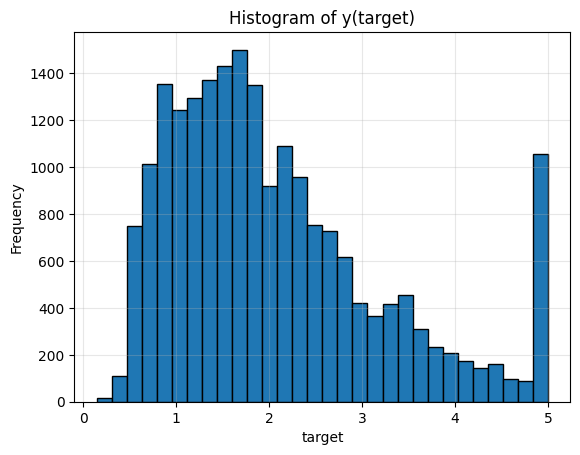

In [ ]:
# 타겟변수(y)의 분포

plt.hist(y, bins=30, edgecolor='black')
plt.title("Histogram of y(target)")
plt.xlabel("target")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 해당 데이터셋의 타겟변수(중위 주택 가격) 최댓값이 한정되어 있습니다.
print(f"최댓값: {np.max(y)}, 개수: {y[y['target'] == np.max(y)].count()}")

최댓값: 5.00001, 개수: target    965
dtype: int64


In [ ]:
# 5를 초과할 경우 모두 동일한 값으로 일괄처리 되었다고 가정하고, 본 과제에서는 이 값들을 제외하겠습니다.

X = X[y['target'] <= 5].reset_index(drop=True)
y = y[y['target'] <= 5].reset_index(drop=True)

### 제거 후 y의 분포 확인

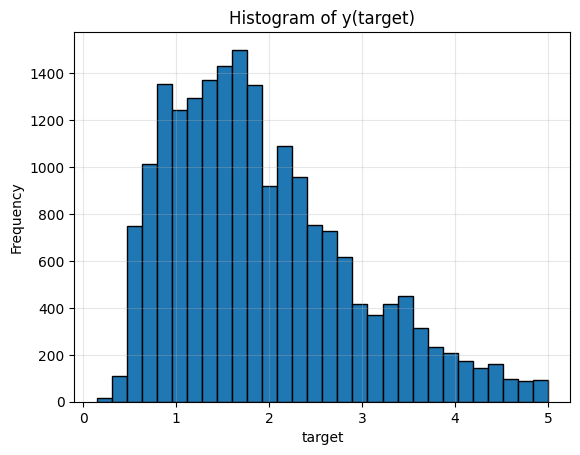

In [ ]:
# 타겟변수(y)의 분포

plt.hist(y, bins=30, edgecolor='black')
plt.title("Histogram of y(target)")
plt.xlabel("target")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

**데이터 분할**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# test size = 0.2, random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# shape 확인
print(X_train.shape, X_test.shape)

(15740, 8) (3935, 8)


## 단일 회귀 모델

In [ ]:
# 선형회귀
from sklearn.linear_model import LinearRegression
# 릿지 (L2 규제)
from sklearn.linear_model import Ridge
# 라쏘 (L1 규제)
from sklearn.linear_model import Lasso
# 엘라스틱넷
from sklearn.linear_model import ElasticNet
# 스케일러
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
# 파이프라인
from sklearn.pipeline import make_pipeline
# 다항회귀
from sklearn.preprocessing import PolynomialFeatures
# 성능평가지표
from sklearn.metrics import r2_score, mean_squared_error

### LinearRegression

In [ ]:
# 모델 정의
lr = LinearRegression()

# 모델 학습
lr.fit(X_train, y_train)

# 예측
lr_pred = lr.predict(X_test)

# 성능 평가
lr_r2 = r2_score(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)

print(f'R2 : {round(lr_r2, 4)}, MSE : {round(lr_mse, 4)}')

R2 : 0.5749, MSE : 0.4239


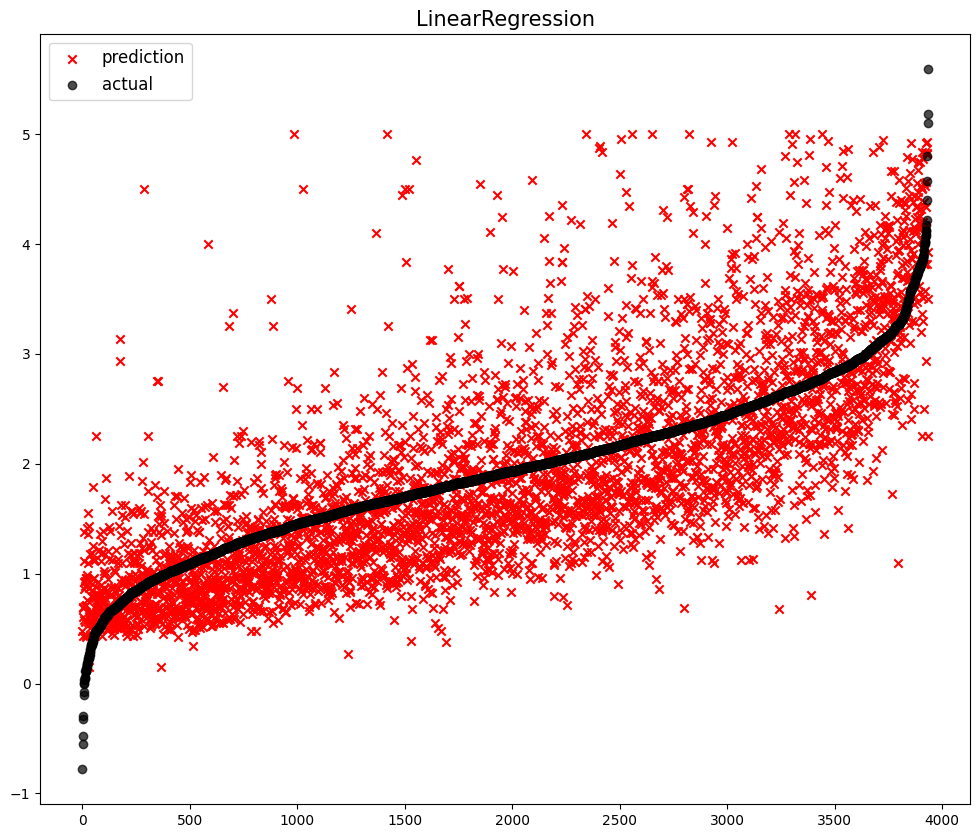

model     error
0  LinearRegression  0.423897

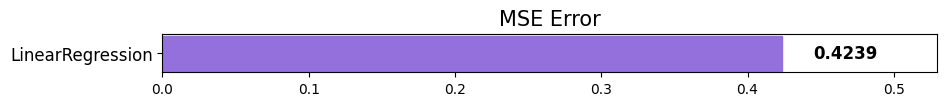

In [ ]:
# 이 코드를 돌리면 예측 결과 시각화 및 각 모델의 성능이 계속 업데이트가 됩니다.
utils.plot_error('LinearRegression', lr_pred, y_test)

### Ridge

In [ ]:
# 모델 정의 (규제 계수인 alpha는 0.1로 적용합니다.)
ridge = Ridge(alpha=0.1)

# 모델 학습
ridge.fit(X_train, y_train)

# 예측
ridge_pred = ridge.predict(X_test)

# 성능 평가
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)

print(f'R2 : {round(ridge_r2, 4)}, MSE : {round(ridge_mse, 4)}')

R2 : 0.5749, MSE : 0.4239


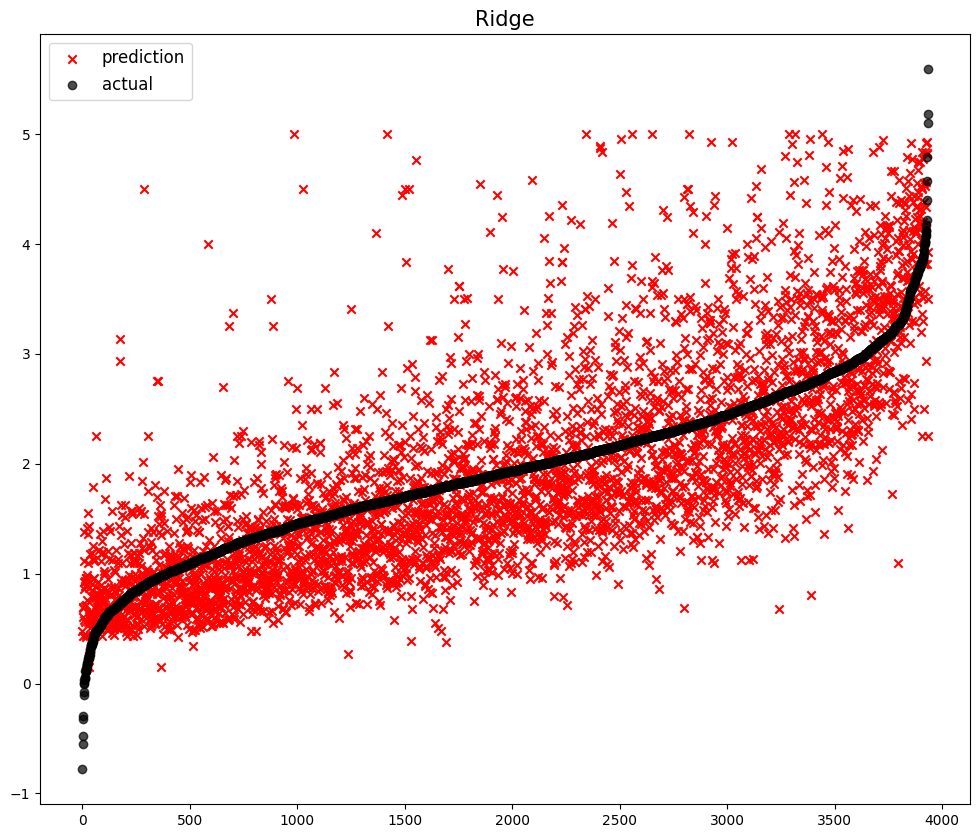

model     error
0             Ridge  0.423898
1  LinearRegression  0.423897

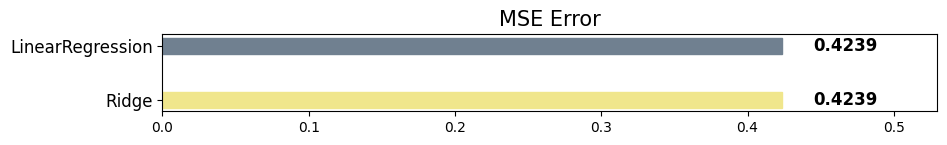

In [ ]:
utils.plot_error('Ridge', ridge_pred, y_test)

### Lasso

In [ ]:
# 모델 정의 (규제 계수인 alpha는 0.01로 적용합니다.)
lasso = Lasso(alpha=0.01)

# 모델 학습
lasso.fit(X_train, y_train)

# 예측
lasso_pred = lasso.predict(X_test)

# 성능 평가
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_mse = mean_squared_error(y_test, lasso_pred)

print(f'R2 : {round(lasso_r2, 4)}, MSE : {round(lasso_mse, 4)}')

R2 : 0.5645, MSE : 0.4342


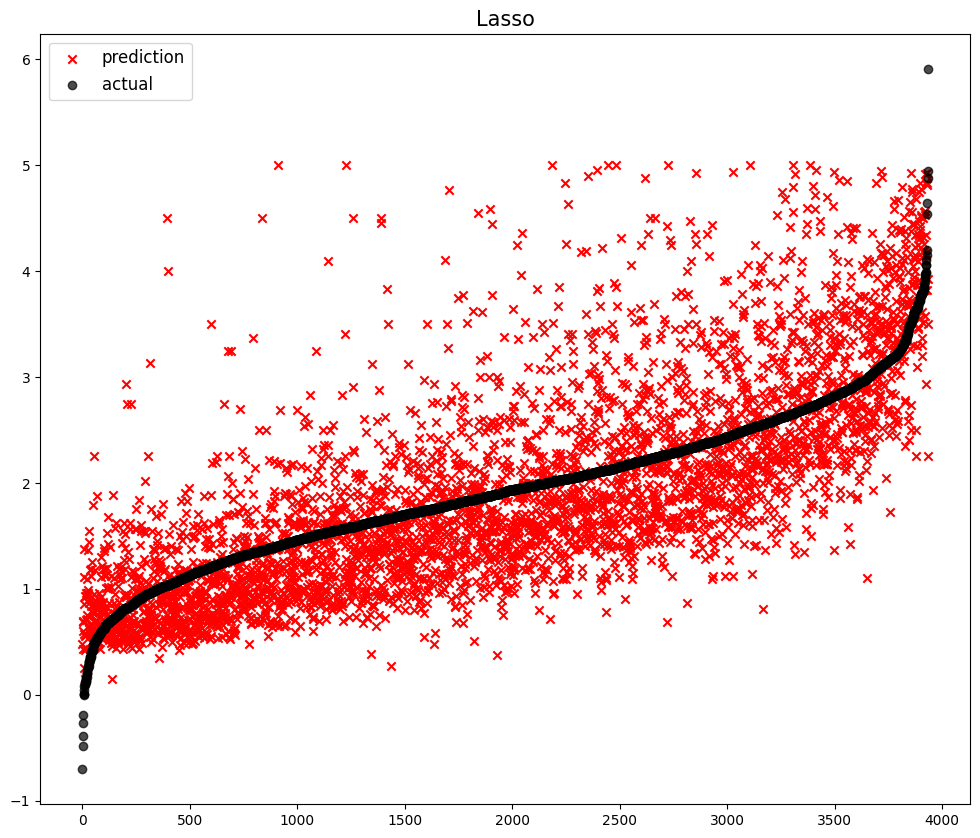

model     error
0             Lasso  0.434209
1             Ridge  0.423898
2  LinearRegression  0.423897

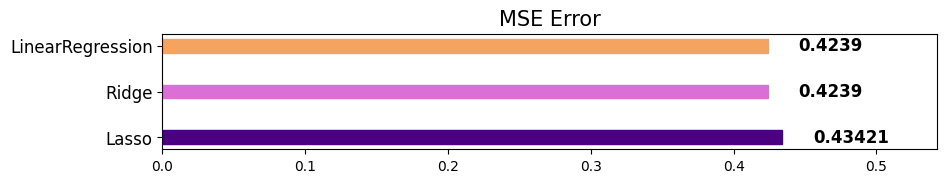

In [ ]:
utils.plot_error('Lasso', lasso_pred, y_test)

### ElasticNet

In [ ]:
# 모델 정의 (규제 계수 `alpha=0.001`, `l1_ratio=0.8` 로 적용합니다.)
elasticnet = ElasticNet(alpha=0.001, l1_ratio=0.8)

# 모델 학습
elasticnet.fit(X_train, y_train)

# 예측
elasticnet_pred = elasticnet.predict(X_test)

# 성능 평가
elasticnet_r2 = r2_score(y_test, elasticnet_pred)
elasticnet_mse = mean_squared_error(y_test, elasticnet_pred)

print(f'R2 : {round(elasticnet_r2, 4)}, MSE : {round(elasticnet_mse, 4)}')

R2 : 0.5744, MSE : 0.4244


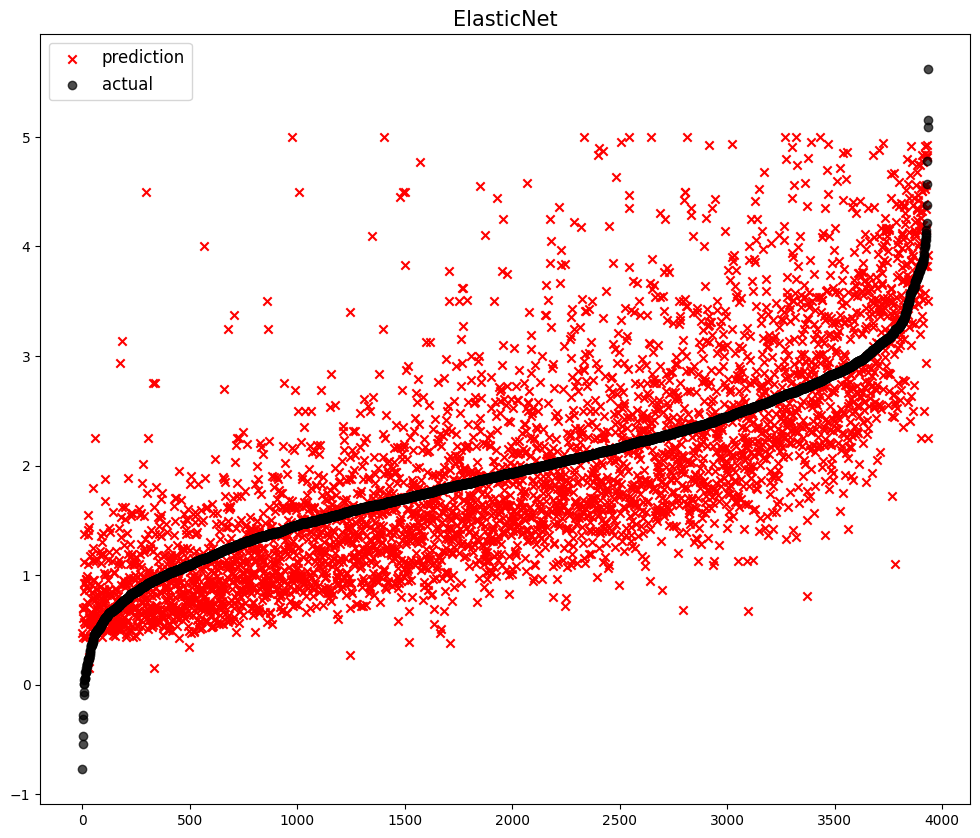

model     error
0             Lasso  0.434209
1        ElasticNet  0.424410
2             Ridge  0.423898
3  LinearRegression  0.423897

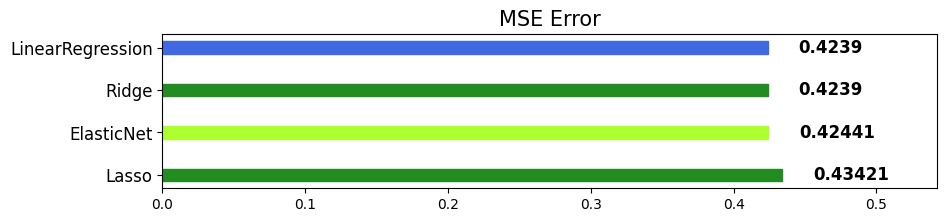

In [ ]:
utils.plot_error('ElasticNet', elasticnet_pred, y_test)

### Pipeline 학습

**파이프라인(Pipeline)** 은 머신러닝에서 여러 단계를 하나의 흐름으로 묶어주는 도구입니다.   
지금까지는 스케일링과 모델학습을 따로 진행했다면, 이를 파이프라인으로 묶어 한번에 처리할 수 있습니다.   
데이터 누수 방지, 코드 간결화 등의 이유로 실무에서도 자주 사용하는 방식이라고 합니다!   

본 과제에서는 **파이프라인 학습**을 통해 StandardScaler와 ElasticNet을 동시에 적용해 보겠습니다.

In [ ]:
# 파이프라인 정의 (규제 계수 `alpha=0.001`, `l1_ratio=0.8`을 적용합니다.)
standard_elasticnet = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.001, l1_ratio=0.8)
)

# 파이프라인 학습
standard_elasticnet.fit(X_train, y_train)

# 예측
standard_elasticnet_pred = standard_elasticnet.predict(X_test)

# 성능 평가
standard_elasticnet_r2 = r2_score(y_test, standard_elasticnet_pred)
standard_elasticnet_mse = mean_squared_error(y_test, standard_elasticnet_pred)

print(f'R2 : {round(standard_elasticnet_r2, 4)}, MSE : {round(standard_elasticnet_mse, 4)}')

R2 : 0.5744, MSE : 0.4244


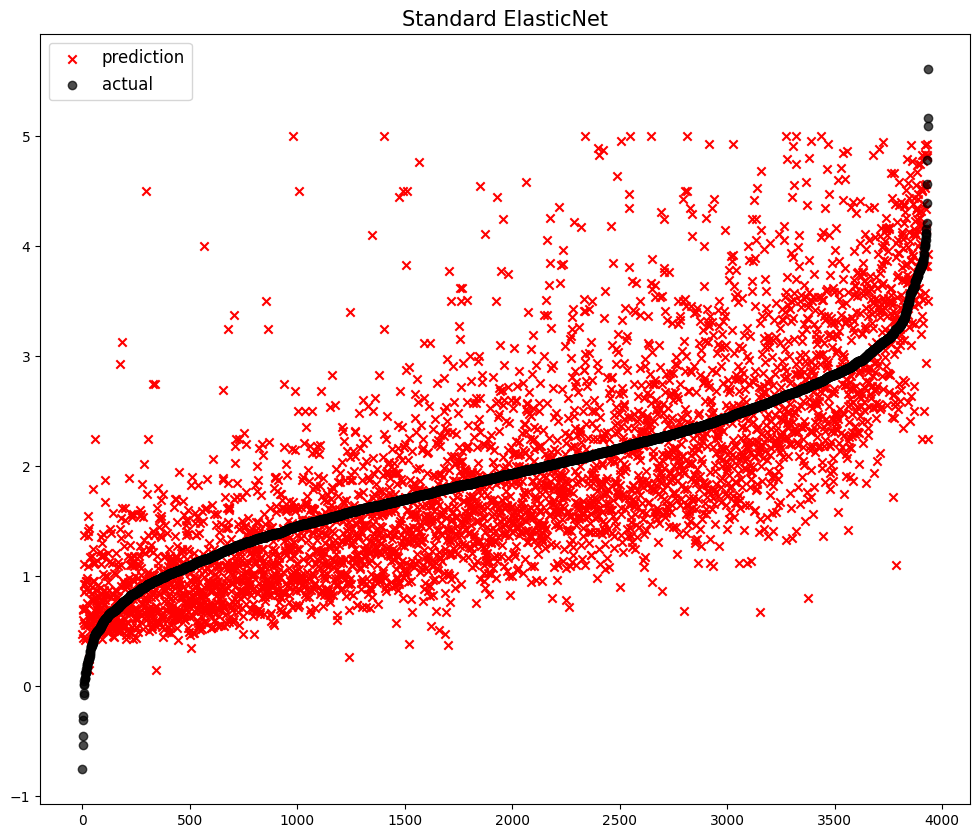

model     error
0                Lasso  0.434209
1           ElasticNet  0.424410
2  Standard ElasticNet  0.424381
3                Ridge  0.423898
4     LinearRegression  0.423897

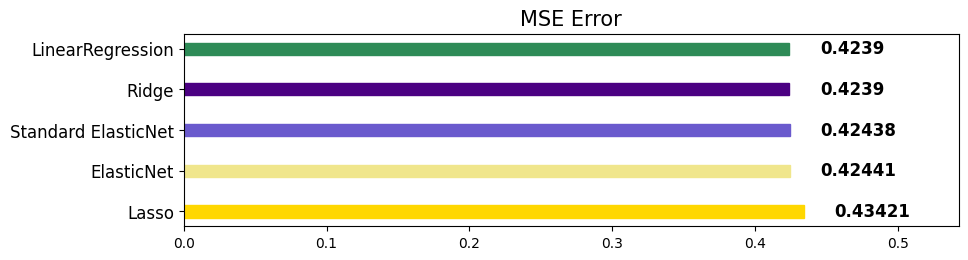

In [ ]:
utils.plot_error('Standard ElasticNet', standard_elasticnet_pred, y_test)

### PolynomialFeatures

PolynomialFeatures는 다항식 회귀모델을 위해 기존 변수들을 다항식으로 만들때 사용했습니다. 기억나시나요?   
이번에는 PolynomialFeatures와 Standard 스케일링을 진행한 ElasticNet의 파이프라인 학습을 진행해보겠습니다.

In [ ]:
# 파이프라인 정의
# (PolynomialFeatures는 `degree=2`, `include_bias=False`를 적용합니다.)
# (ElasticNet 모델은 규제 계수 `alpha=0.001`, `l1_ratio=0.8 을 적용합니다.)
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=0.001, l1_ratio=0.8)
)

# 모델 학습
poly_pipeline.fit(X_train, y_train)

# 예측
poly_pipeline_pred = poly_pipeline.predict(X_test)

# 성능 평가
poly_pipeline_r2 = r2_score(y_test, poly_pipeline_pred)
poly_pipeline_mse = mean_squared_error(y_test, poly_pipeline_pred)

print(f'R2 : {round(poly_pipeline_r2, 4)}, MSE : {round(poly_pipeline_mse, 4)}')

R2 : 0.6074, MSE : 0.3915


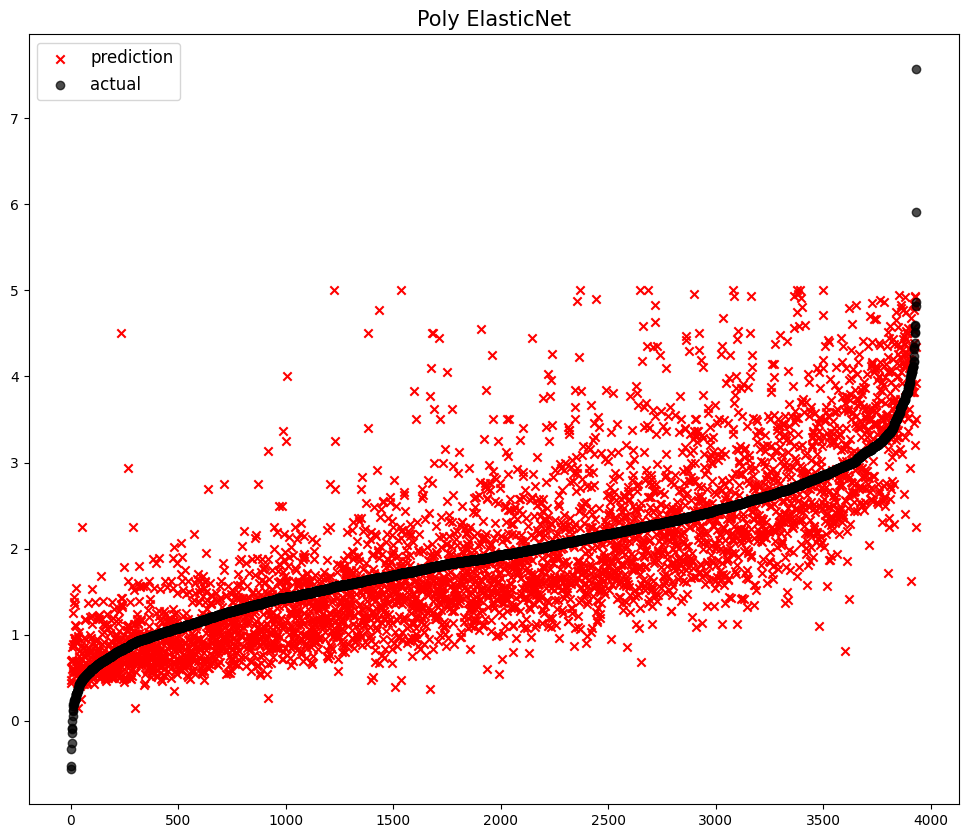

model     error
0                Lasso  0.434209
1           ElasticNet  0.424410
2  Standard ElasticNet  0.424381
3                Ridge  0.423898
4     LinearRegression  0.423897
5      Poly ElasticNet  0.391494

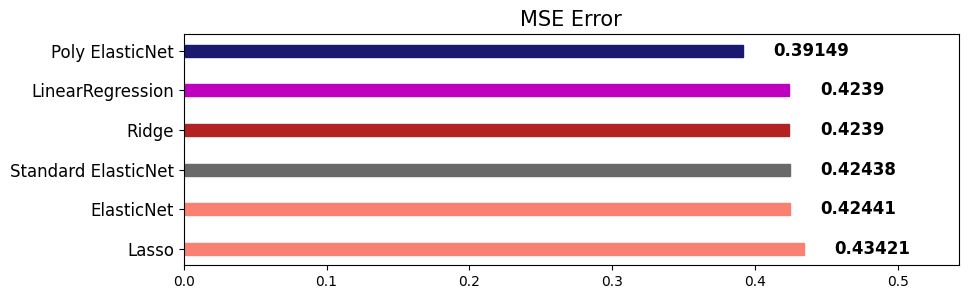

In [ ]:
utils.plot_error('Poly ElasticNet', poly_pipeline_pred, y_test)

## 앙상블 모델

### 보팅 (Voting) - 회귀 (Regression)

Voting은 단어 뜻 그대로 **투표를 통해 결정하는 방식**입니다. Voting은 Bagging과 투표방식이라는 점에서 유사하지만, 다음과 같은 큰 차이점이 있습니다.

- Voting은 다른 알고리즘 model을 조합해서 사용합니다.
- Bagging은 같은 알고리즘 내에서 다른 sample 조합을 사용합니다.

In [ ]:
from sklearn.ensemble import VotingRegressor, VotingClassifier

반드시, **Tuple 형태로 모델**을 정의해야 합니다.

In [ ]:
single_models = [
    ('lr', lr),
    ('ridge', ridge),
    ('lasso', lasso),
    ('standard_elasticnet', standard_elasticnet),
    ('poly_pipeline', poly_pipeline)
]

In [ ]:
voting_regressor = VotingRegressor(
    estimators=single_models,
)

In [ ]:
voting_regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('ridge', Ridge(alpha=0.1)),
                            ('lasso', Lasso(alpha=0.01)),
                            ('standard_elasticnet',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('elasticnet',
                                              ElasticNet(alpha=0.001,
                                                         l1_ratio=0.8))])),
                            ('poly_pipeline',
                             Pipeline(steps=[('polynomialfeatures',
                                              PolynomialFeatures(include_bias=False)),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('elasticnet',
                                              ElasticNet(alpha=0.001,
                                                         l1_ratio=0.8))]))])

In [ ]:
voting_pred = voting_regressor.predict(X_test)

In [ ]:
# 성능 평가
voting_r2 = r2_score(y_test, voting_pred)
voting_mse = mean_squared_error(y_test, voting_pred)

print(f'R2 : {round(voting_r2, 4)}, MSE : {round(voting_mse, 4)}')

R2 : 0.5835, MSE : 0.4153


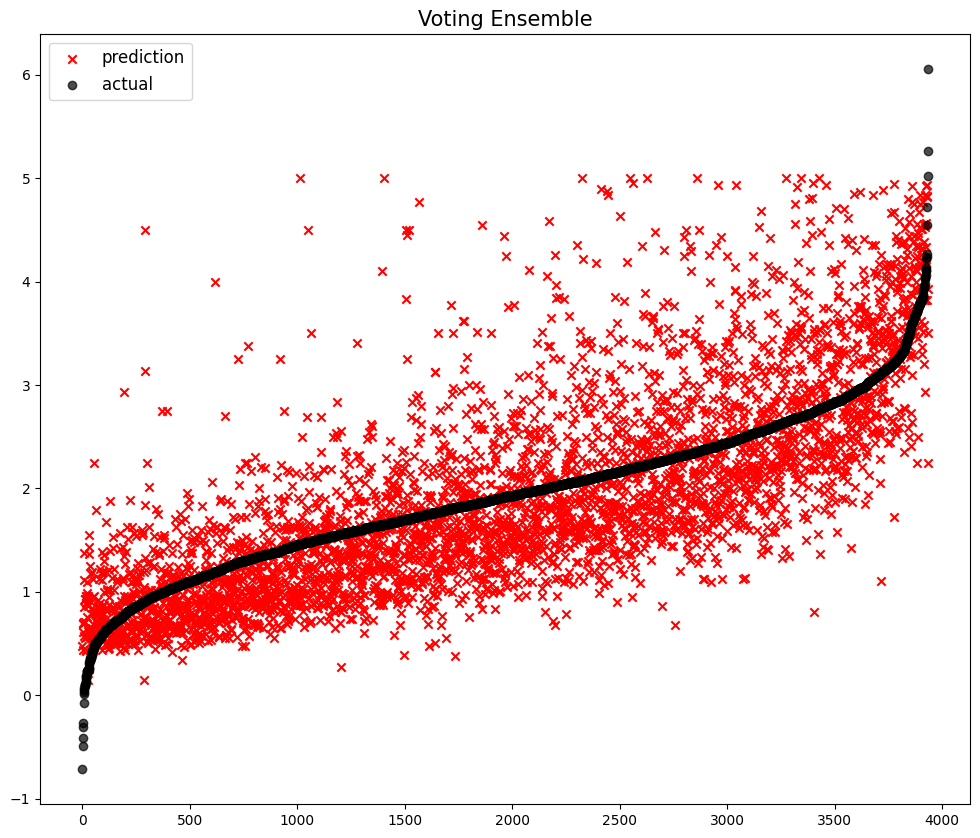

model     error
0                Lasso  0.434209
1           ElasticNet  0.424410
2  Standard ElasticNet  0.424381
3                Ridge  0.423898
4     LinearRegression  0.423897
5      Voting Ensemble  0.415333
6      Poly ElasticNet  0.391494

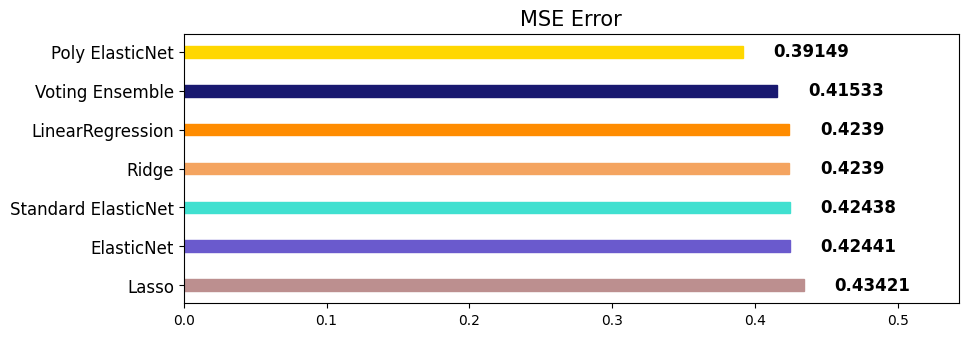

In [ ]:
utils.plot_error('Voting Ensemble', voting_pred, y_test)

## 보팅 (Voting) - 분류 (Classification)

[자세한 내용 보기](https://teddylee777.github.io/machine-learning/ensemble%EA%B8%B0%EB%B2%95%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4%EC%99%80-%EC%A2%85%EB%A5%98-1)

분류기 모델을 만들때, Voting 앙상블은 1가지의 **중요한 parameter**가 있습니다.   
`voting` = {'hard', 'soft'}

#### **hard** voting

class를 0, 1로 분류 예측을 하는 이진 분류를 예로 들어 보겠습니다.   
   
Hard Voting 방식에서는 결과 값에 대한 다수 class를 차용합니다.   
분류를 예측한 값이 1, 0, 0, 1, 1 이었다고 가정한다면, 1이 3표, 0이 2표를 받았기 때문에 Hard Voting 방식에서는 1이 최종 값으로 예측을 하게 됩니다.

#### **soft** voting

Soft Voting 방식은 각각의 확률의 평균 값을 계산한 다음에 가장 확률이 높은 값으로 확정짓게 됩니다.

가령 class 0이 나올 확률이 (0.4, 0.9, 0.9, 0.4, 0.4)이었고, class 1이 나올 확률이 (0.6, 0.1, 0.1, 0.6, 0.6) 이었다면,

- class 0이 나올 최종 확률은 (0.4+0.9+0.9+0.4+0.4) / 5 = 0.44,
- class 1이 나올 최종 확률은 (0.6+0.1+0.1+0.6+0.6) / 5 = 0.4

가 되기 때문에 앞선 Hard Voting과는 다른 결과가 최종 산출됩니다.   

#### 참고) **회귀**에서의 보팅

회귀에서 Voting과 Soft Voting이 헷갈릴 수 있는데, 두 방식은 서로 다른 개념입니다.   
- Soft Voting은 각 모델이 특정 클래스라고 예측한 확률의 평균을 구함
- 회귀에서의 Voting은 모든 회귀기의 예측값을 단순 평균하에 최종 예측을 함
   
그래서 사실 Hard / Soft Voting이라는 용어도 분류에서만 쓰이는 개념인 것이죠!

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [ ]:
models = [
    ('Logi', LogisticRegression()),
    ('ridge', RidgeClassifier())
]

In [ ]:
# voting 옵션에 대하여 지정합니다.
vc = VotingClassifier(models, voting='soft')

In [ ]:
vc.fit(X_train, y_train)
y_vc_pred = vc.predict(X_test)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

## 배깅(Bagging)

Bootstrap + Aggregating   
1. 부트스트랩을 통해 전체 데이터셋에서 중복을 허용하여 무작위로 재표본 추출을 하고,
2. 동일한 알고리즘 모델을 사용해 각각의 샘플을 독립적으로 학습하고,
3. 모든 모델의 예측값을 결합해 최종 결과를 도출하는 방법입니다.

[자세한 내용 보기](https://teddylee777.github.io/machine-learning/ensemble%EA%B8%B0%EB%B2%95%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4%EC%99%80-%EC%A2%85%EB%A5%98-2)

**Voting VS Bagging**

* **Voting**이 여러 알고리즘의 조합에 대한 앙상블이라면...
* **Bagging**은 하나의 단일 알고리즘에 대하여 여러 개의 샘플 조합으로 앙상블한다는 차이가 있습니다.

### RandomForest

- DecisionTree기반 Bagging 앙상블 모델입니다.
- 사용이 쉽고, 성능도 우수해서 매우 인기가 많습니다.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
# 모델 정의 (random_state = 42)
rfr = RandomForestRegressor(random_state=42)

# 모델 학습
rfr.fit(X_train, y_train)

# 예측
rfr_pred = rfr.predict(X_test)

# 성능 평가
rfr_r2 = r2_score(y_test, rfr_pred)
rfr_mse = mean_squared_error(y_test, rfr_pred)

print(f'R2 : {round(rfr_r2, 4)}, MSE : {round(rfr_mse, 4)}')

R2 : 0.776, MSE : 0.2234


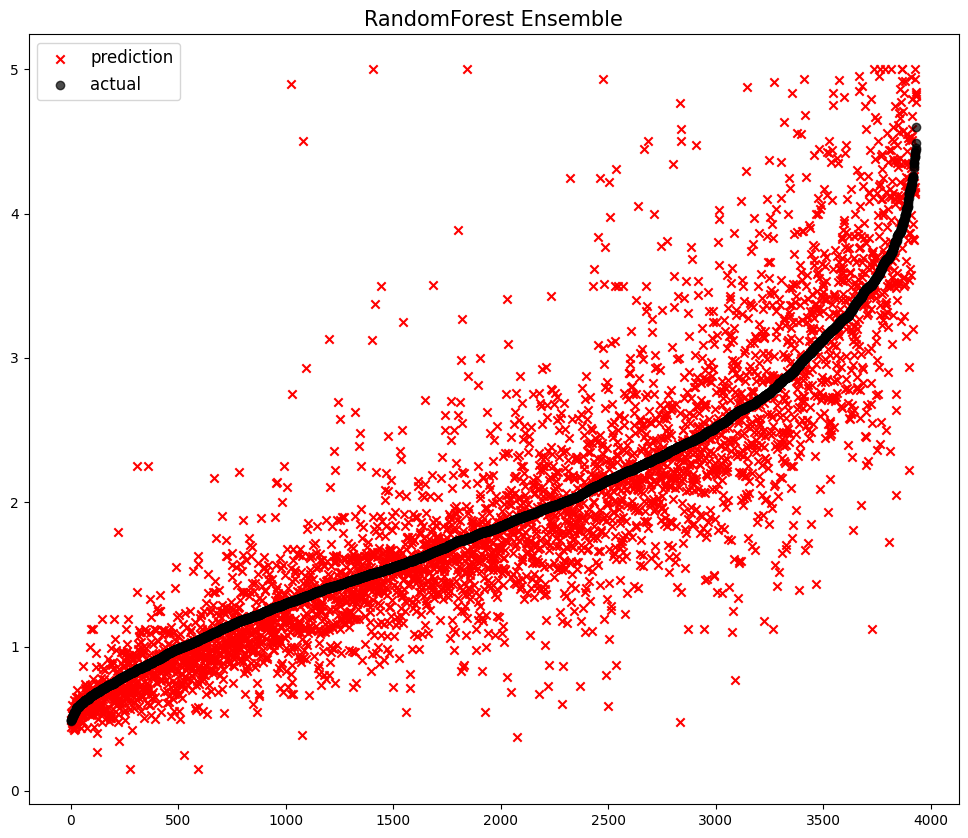

model     error
0                  Lasso  0.434209
1             ElasticNet  0.424410
2    Standard ElasticNet  0.424381
3                  Ridge  0.423898
4       LinearRegression  0.423897
5        Voting Ensemble  0.415333
6        Poly ElasticNet  0.391494
7  RandomForest Ensemble  0.223379

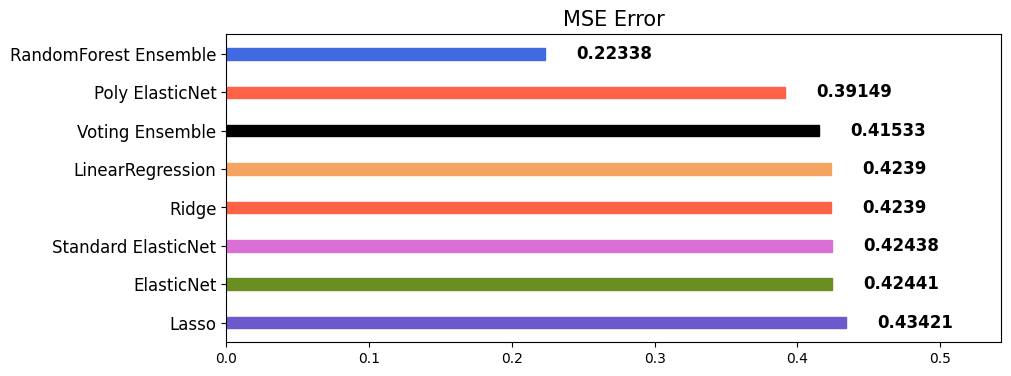

In [ ]:
utils.plot_error('RandomForest Ensemble', rfr_pred, y_test)

**주요 Hyperparameter**

- `random_state`: 랜덤 시드 값. 고정해두고 튜닝할 것!
- `n_jobs`: CPU 사용 개수
- `max_depth`: 깊어질 수 있는 최대 깊이. 과대적합 방지용
- `n_estimators`: 앙상블하는 트리의 개수
- `max_features`: 최대로 사용할 feature의 개수. 과대적합 방지용
- `min_samples_split`: 트리가 분할할 때 최소 샘플의 개수. default=2. 과대적합 방지용

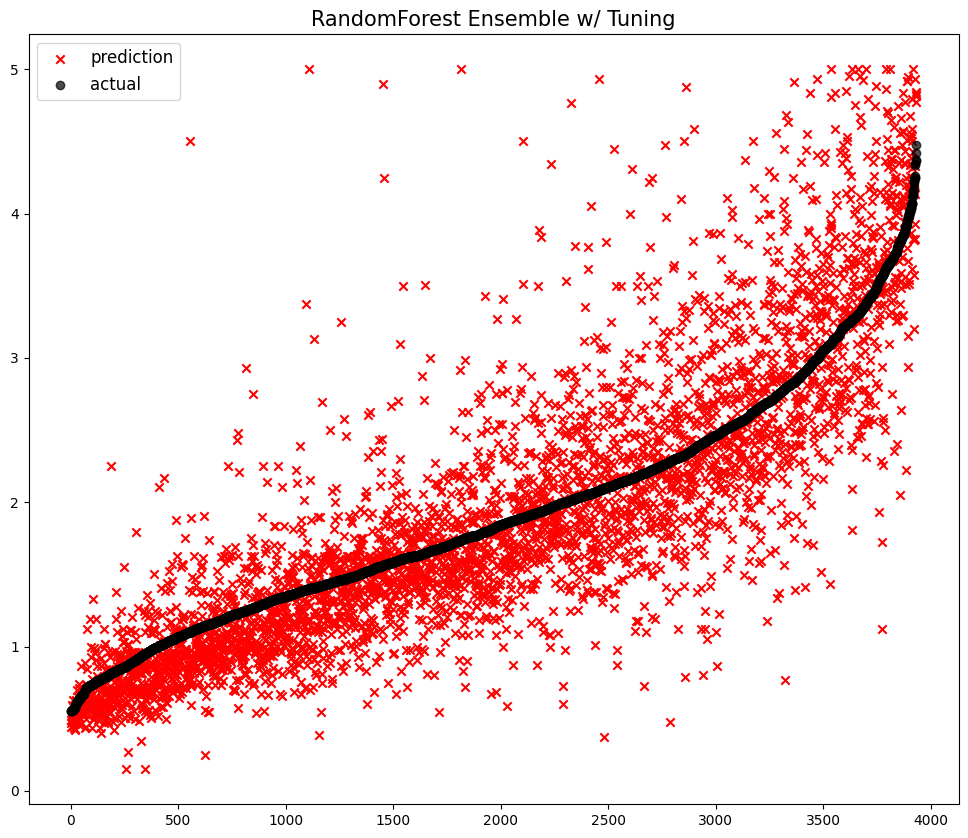

model     error
0                            Lasso  0.434209
1                       ElasticNet  0.424410
2              Standard ElasticNet  0.424381
3                            Ridge  0.423898
4                 LinearRegression  0.423897
5                  Voting Ensemble  0.415333
6                  Poly ElasticNet  0.391494
7  RandomForest Ensemble w/ Tuning  0.266462
8            RandomForest Ensemble  0.223379

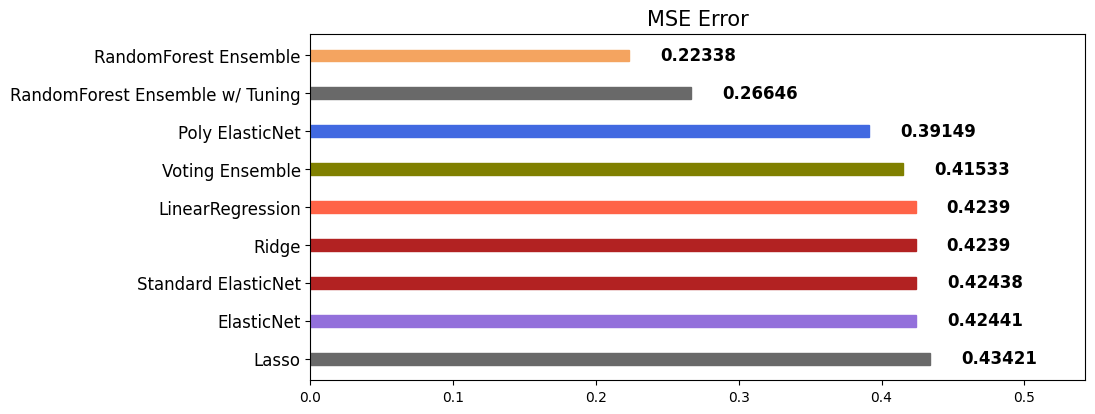

In [ ]:
# 위 하이퍼파라미터를 직접 지정할 수도 있습니다.
# 물론 최적의 파라미터를 찾기 위해서는 튜닝 과정을 거쳐야 합니다. (밑에서 잠깐 나옵니다.)

# 주의) 튜닝을 할 땐 반드시 random_state 값을 고정시켜야 합니다!

rfr = RandomForestRegressor(random_state=42, n_estimators=1500, max_depth=9, max_features=0.9)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
utils.plot_error('RandomForest Ensemble w/ Tuning', rfr_pred, y_test)

## 부스팅 (Boosting)

[자세한 내용 보기]('https://teddylee777.github.io/machine-learning/ensemble%EA%B8%B0%EB%B2%95%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4%EC%99%80-%EC%A2%85%EB%A5%98-3')

약한 학습기를 순차적으로 학습을 하되, 이전 학습에 대하여 잘못 예측된 데이터에 **가중치를 부여해 오차를 보완**해 나가는 방식입니다.

**장점**
- 성능이 매우 우수합니다. (Lgbm, XGBoost 등)

**단점**
- 부스팅 알고리즘의 특성상 계속 약점(오분류/잔차)을 보완하려고 하기 때문에 **잘못된 레이블링이나 아웃라이어에 필요 이상으로 민감**할 수 있습니다.
- 순차적이기 때문에 병렬처리에 어려움이 있고, 그렇다보니 **학습 시간이 오래걸립니다.**.

### GradientBoost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

In [ ]:
# 모델 정의 (random_state = 42)
gbr = GradientBoostingRegressor(random_state=42)

# 모델 학습
gbr.fit(X_train, y_train)

# 예측
gbr_pred = gbr.predict(X_test)

# 성능 평가
gbr_r2 = r2_score(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)

print(f'R2 : {round(gbr_r2, 4)}, MSE : {round(gbr_mse, 4)}')

R2 : 0.7507, MSE : 0.2486


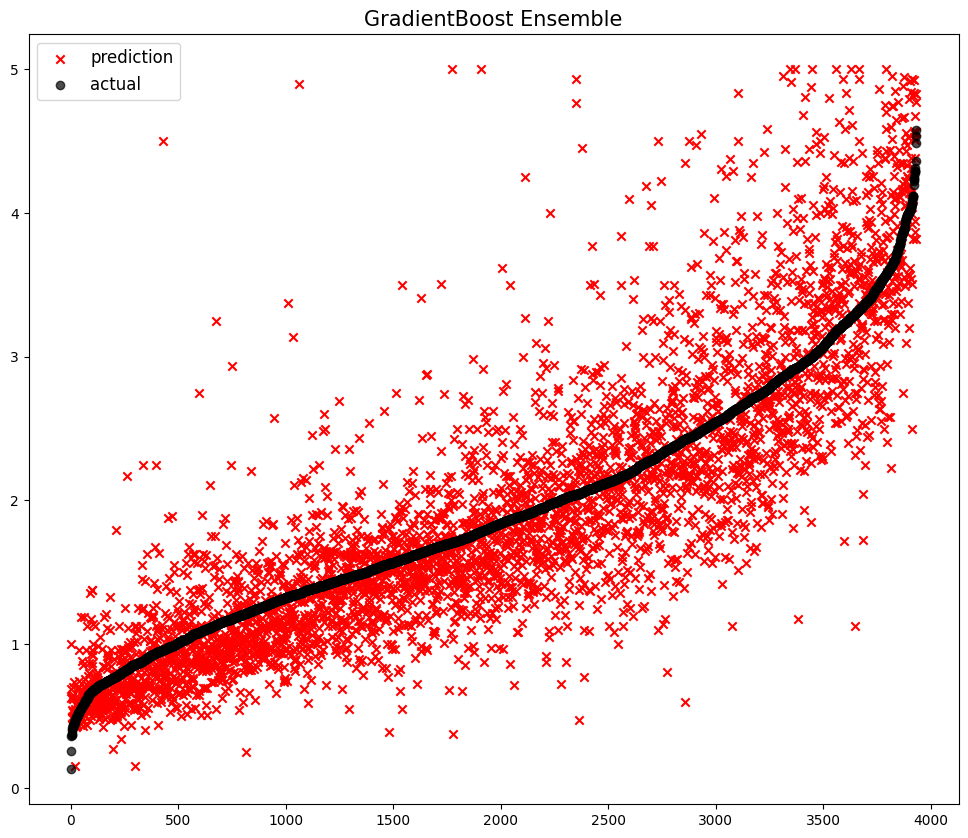

model     error
0                            Lasso  0.434209
1                       ElasticNet  0.424410
2              Standard ElasticNet  0.424381
3                            Ridge  0.423898
4                 LinearRegression  0.423897
5                  Voting Ensemble  0.415333
6                  Poly ElasticNet  0.391494
7  RandomForest Ensemble w/ Tuning  0.266462
8           GradientBoost Ensemble  0.248581
9            RandomForest Ensemble  0.223379

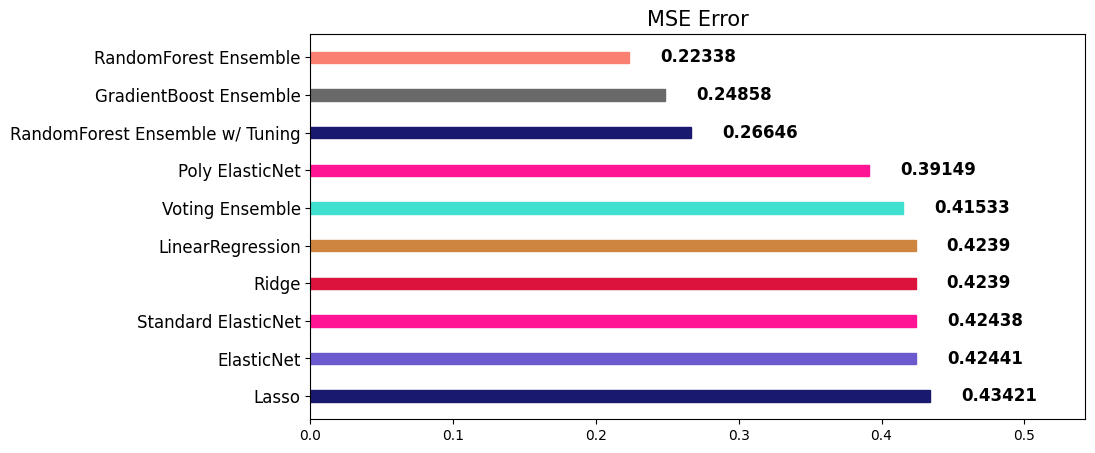

In [ ]:
utils.plot_error('GradientBoost Ensemble', gbr_pred, y_test)

**주요 Hyperparameter**
- `random_state`: 랜덤 시드 값. 고정해두고 튜닝할 것!
- `n_jobs`: CPU 사용 개수
- `learning_rate`: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1
- `n_estimators`: 부스팅 스테이지 수. (랜덤포레스트 트리의 개수 설정과 비슷한 개념). default=100
- `subsample`: 샘플 사용 비율 (max_features와 비슷한 개념). 과대적합 방지용
- `min_samples_split`: 노드 분할시 최소 샘플의 개수. default=2. 과대적합 방지용

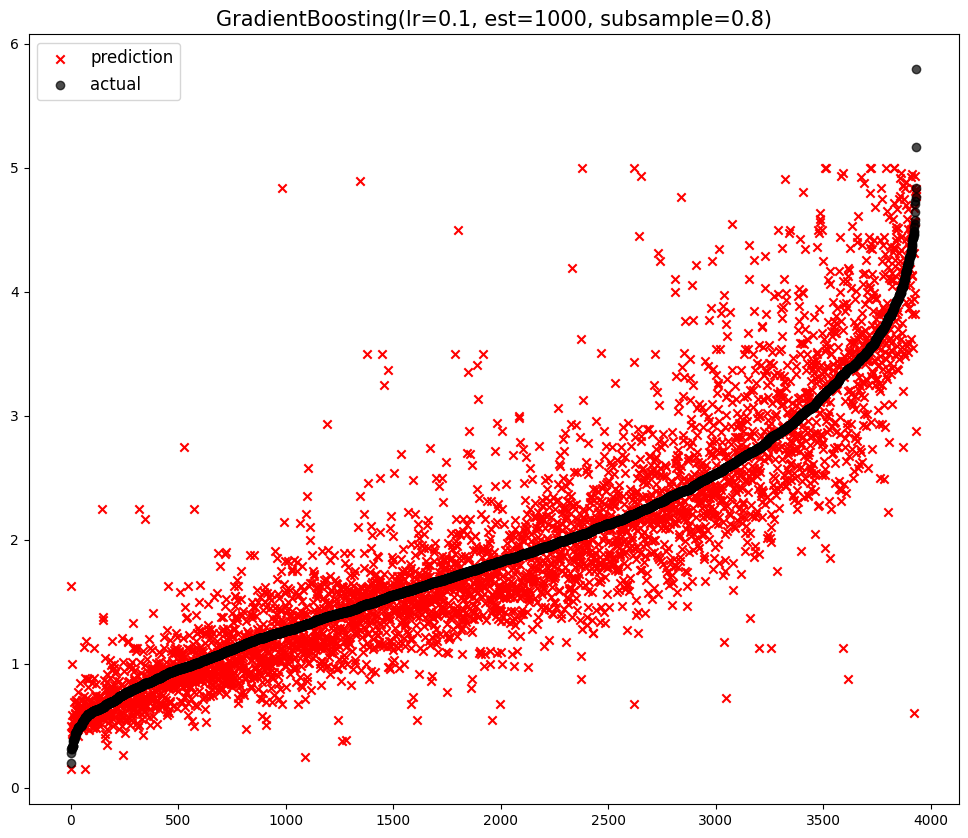

model     error
0                                               Lasso  0.434209
1                                          ElasticNet  0.424410
2                                 Standard ElasticNet  0.424381
3                                               Ridge  0.423898
4                                    LinearRegression  0.423897
5                                     Voting Ensemble  0.415333
6                                     Poly ElasticNet  0.391494
7                     RandomForest Ensemble w/ Tuning  0.266462
8                              GradientBoost Ensemble  0.248581
9                               RandomForest Ensemble  0.223379
10  GradientBoosting(lr=0.1, est=1000, subsample=0.7)  0.196520
11  GradientBoosting(lr=0.01, est=1000, subsample=...  0.196385
12  GradientBoosting(lr=0.1, est=1000, subsample=0.8)  0.196385

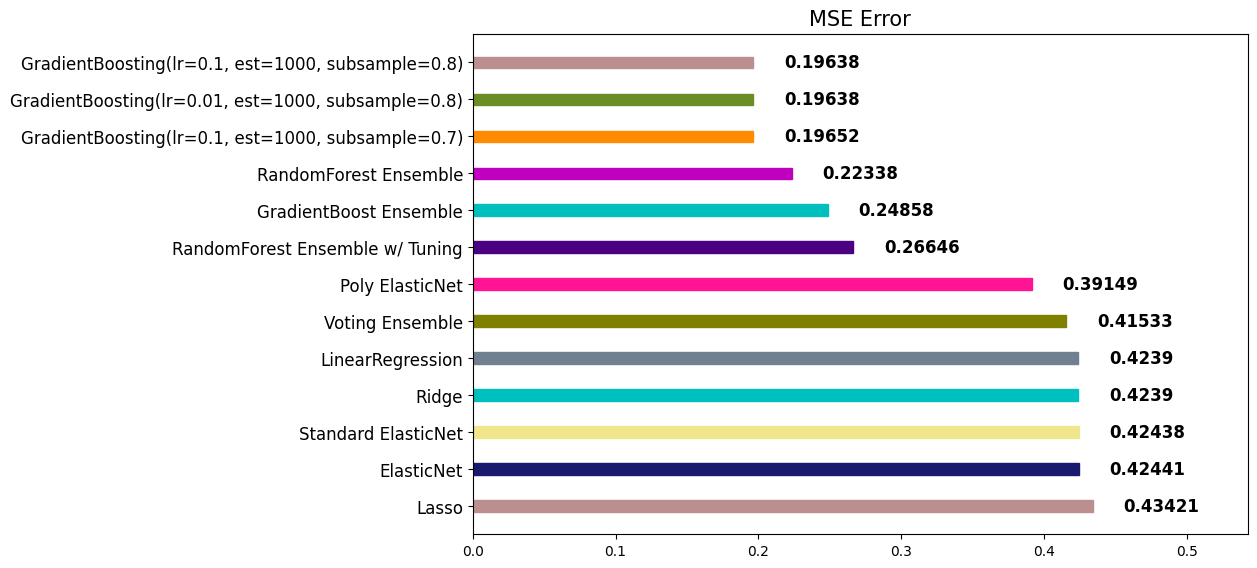

In [ ]:
# 하이퍼파라미터 튜닝 수작업 Ver.
# 원하는 값들을 입력하면서 결과를 비교해보세요
gbr = GradientBoostingRegressor(random_state=42, learning_rate=0.1, n_estimators=1000, subsample=0.8)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
utils.plot_error('GradientBoosting(lr=0.1, est=1000, subsample=0.8)', gbr_pred, y_test)

### XGBoost
e**X**treme **G**radient **B**oosting

In [ ]:
from xgboost import XGBRegressor, XGBClassifier

In [ ]:
# 모델 정의 (random_state = 42)
xgb = XGBRegressor(random_state=42)

# 모델 학습
xgb.fit(X_train, y_train)

# 예측
xgb_pred = xgb.predict(X_test)

# 성능 평가
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)

print(f'R2 : {round(xgb_r2, 4)}, MSE : {round(xgb_mse, 4)}')

R2 : 0.8075, MSE : 0.192


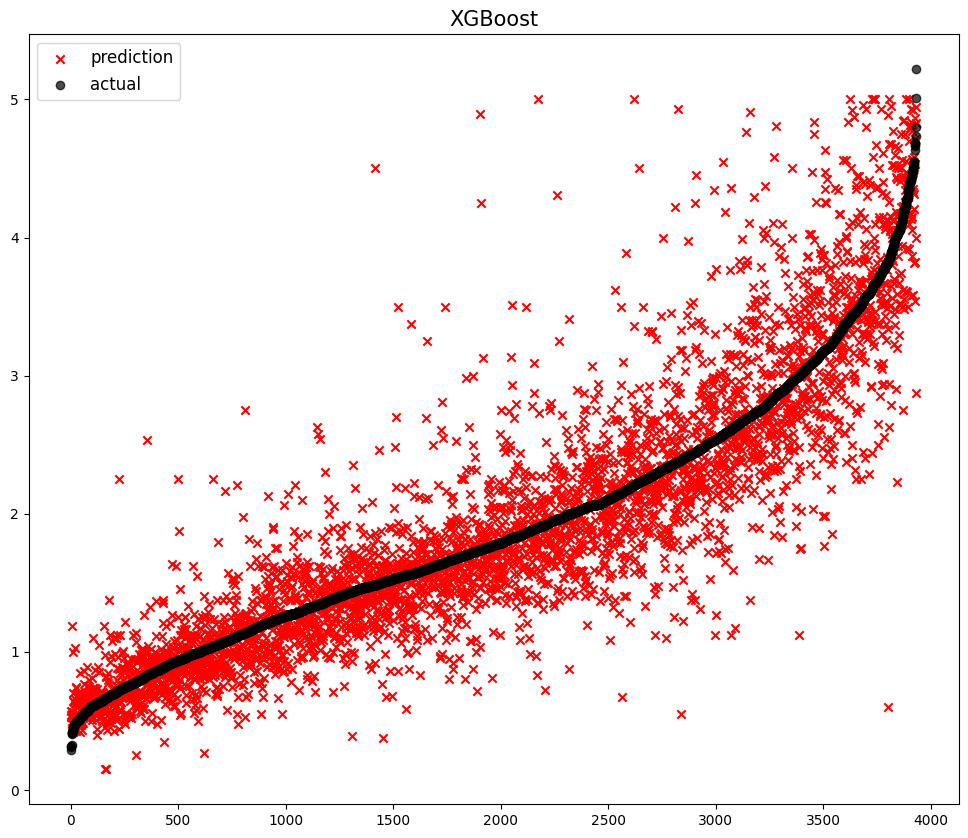

model     error
0                                               Lasso  0.434209
1                                          ElasticNet  0.424410
2                                 Standard ElasticNet  0.424381
3                                               Ridge  0.423898
4                                    LinearRegression  0.423897
5                                     Voting Ensemble  0.415333
6                                     Poly ElasticNet  0.391494
7                     RandomForest Ensemble w/ Tuning  0.266462
8                              GradientBoost Ensemble  0.248581
9                               RandomForest Ensemble  0.223379
10  GradientBoosting(lr=0.1, est=1000, subsample=0.7)  0.196520
11  GradientBoosting(lr=0.01, est=1000, subsample=...  0.196385
12  GradientBoosting(lr=0.1, est=1000, subsample=0.8)  0.196385
13                                            XGBoost  0.191983

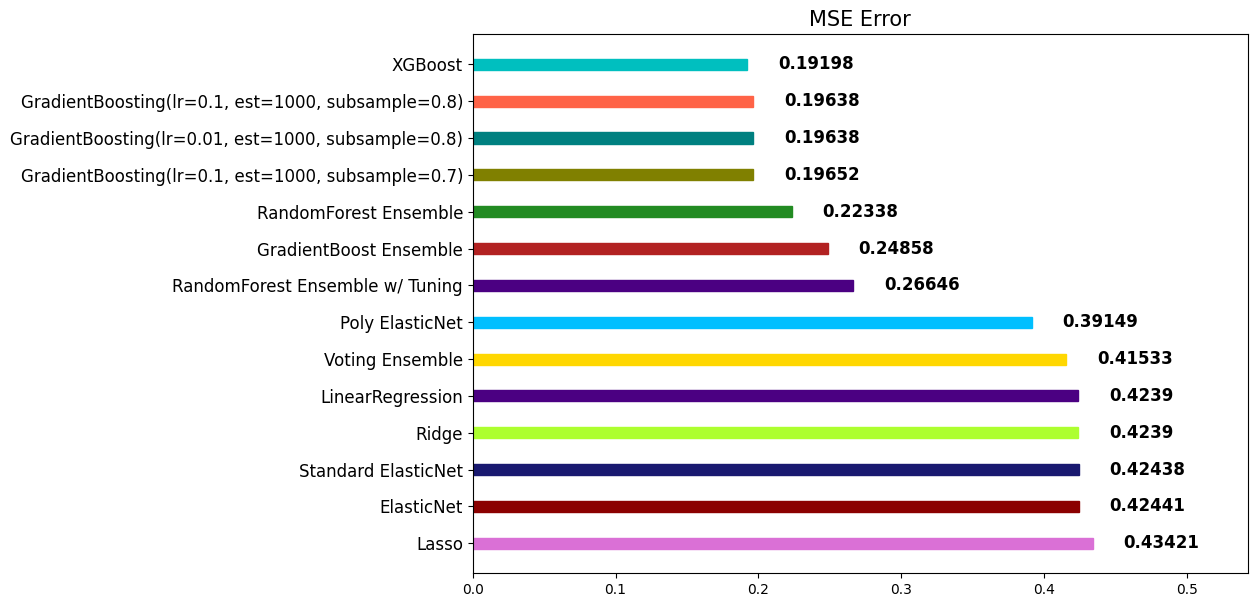

In [ ]:
utils.plot_error('XGBoost', xgb_pred, y_test)

**주요 Hyperparameter**
- `random_state`: 랜덤 시드 고정 값. 고정해두고 튜닝할 것!
- `n_jobs`: CPU 사용 갯수
- `learning_rate`: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1
- `n_estimators`: 부스팅 스테이지 수. (랜덤포레스트 트리의 갯수 설정과 비슷한 개념). default=100
- `max_depth`: 트리의 깊이. 과대적합 방지용. default=3.
- `subsample`: 샘플 사용 비율. 과대적합 방지용. default=1.0
- `colsample_bytree`: 최대로 사용할 feature의 비율. 과대적합 방지용. default=1.0

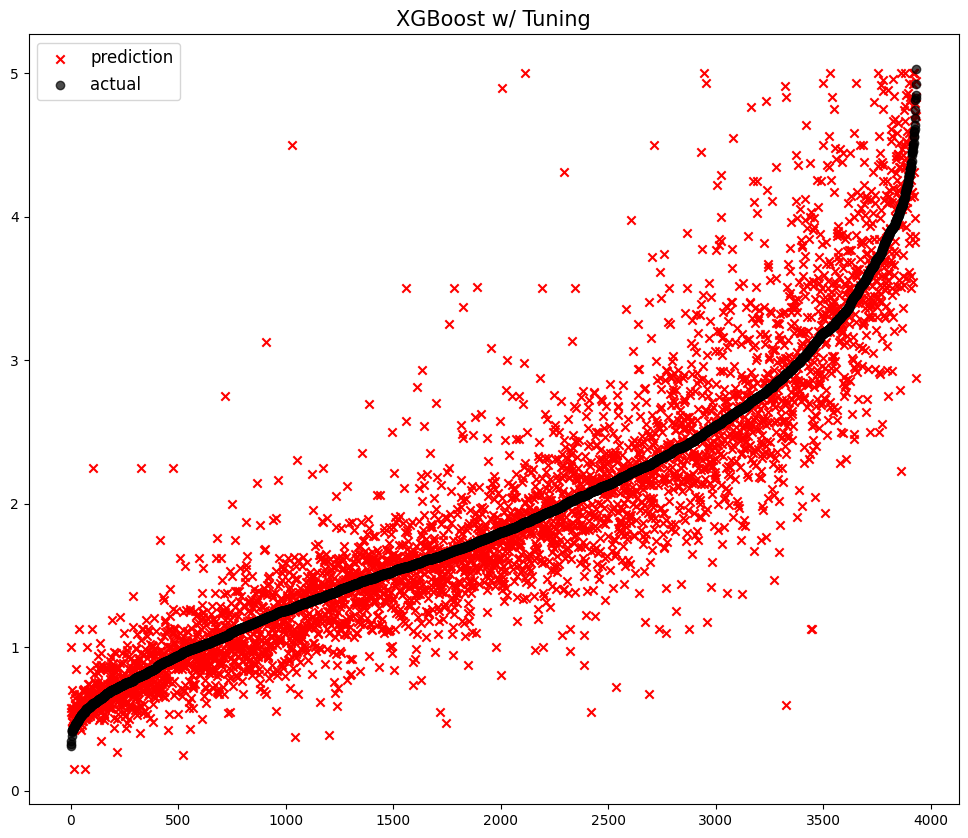

model     error
0                                               Lasso  0.434209
1                                          ElasticNet  0.424410
2                                 Standard ElasticNet  0.424381
3                                               Ridge  0.423898
4                                    LinearRegression  0.423897
5                                     Voting Ensemble  0.415333
6                                     Poly ElasticNet  0.391494
7                     RandomForest Ensemble w/ Tuning  0.266462
8                              GradientBoost Ensemble  0.248581
9                               RandomForest Ensemble  0.223379
10  GradientBoosting(lr=0.1, est=1000, subsample=0.7)  0.196520
11  GradientBoosting(lr=0.01, est=1000, subsample=...  0.196385
12  GradientBoosting(lr=0.1, est=1000, subsample=0.8)  0.196385
13                                            XGBoost  0.191983
14                                  XGBoost w/ Tuning  0.169448

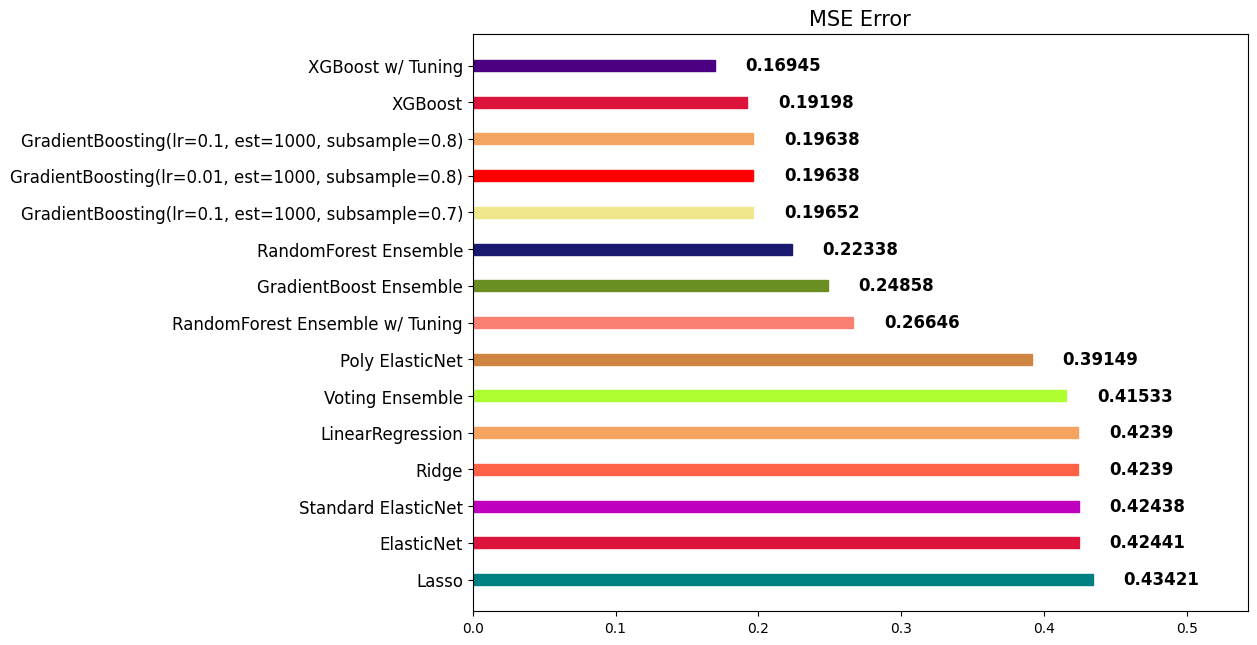

In [ ]:
# 하이퍼파라미터 튜닝 수작업 Ver
xgb = XGBRegressor(random_state=42, learning_rate=0.1, n_estimators=1000, subsample=0.8, colsample_bytree=0.8, max_depth=7)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
utils.plot_error('XGBoost w/ Tuning', xgb_pred, y_test)

### LightGBM

In [ ]:
from lightgbm import LGBMRegressor, LGBMClassifier

In [ ]:
# 모델 정의 (random_state = 42)
lgbm = LGBMRegressor(random_state=42)

# 모델 학습
lgbm.fit(X_train, y_train)

# 예측
lgbm_pred = lgbm.predict(X_test)

# 성능 평가
lgbm_r2 = r2_score(y_test, lgbm_pred)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)

print(f'R2 : {round(lgbm_r2, 4)}, MSE : {round(lgbm_mse, 4)}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15740, number of used features: 8
[LightGBM] [Info] Start training from score 1.921911
R2 : 0.8114, MSE : 0.188


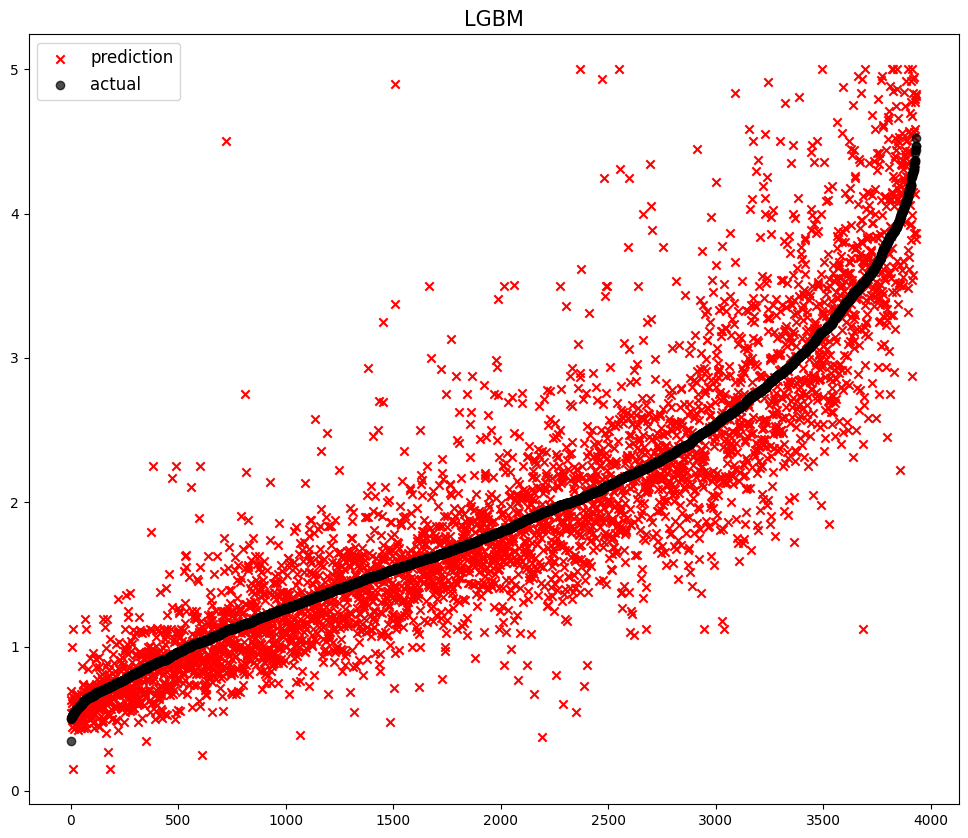

model     error
0                                               Lasso  0.434209
1                                          ElasticNet  0.424410
2                                 Standard ElasticNet  0.424381
3                                               Ridge  0.423898
4                                    LinearRegression  0.423897
5                                     Voting Ensemble  0.415333
6                                     Poly ElasticNet  0.391494
7                     RandomForest Ensemble w/ Tuning  0.266462
8                              GradientBoost Ensemble  0.248581
9                               RandomForest Ensemble  0.223379
10  GradientBoosting(lr=0.1, est=1000, subsample=0.7)  0.196520
11  GradientBoosting(lr=0.01, est=1000, subsample=...  0.196385
12  GradientBoosting(lr=0.1, est=1000, subsample=0.8)  0.196385
13                                            XGBoost  0.191983
14                                               LGBM  0.188020
15                                  XGBoost w/ Tuning  0.169448

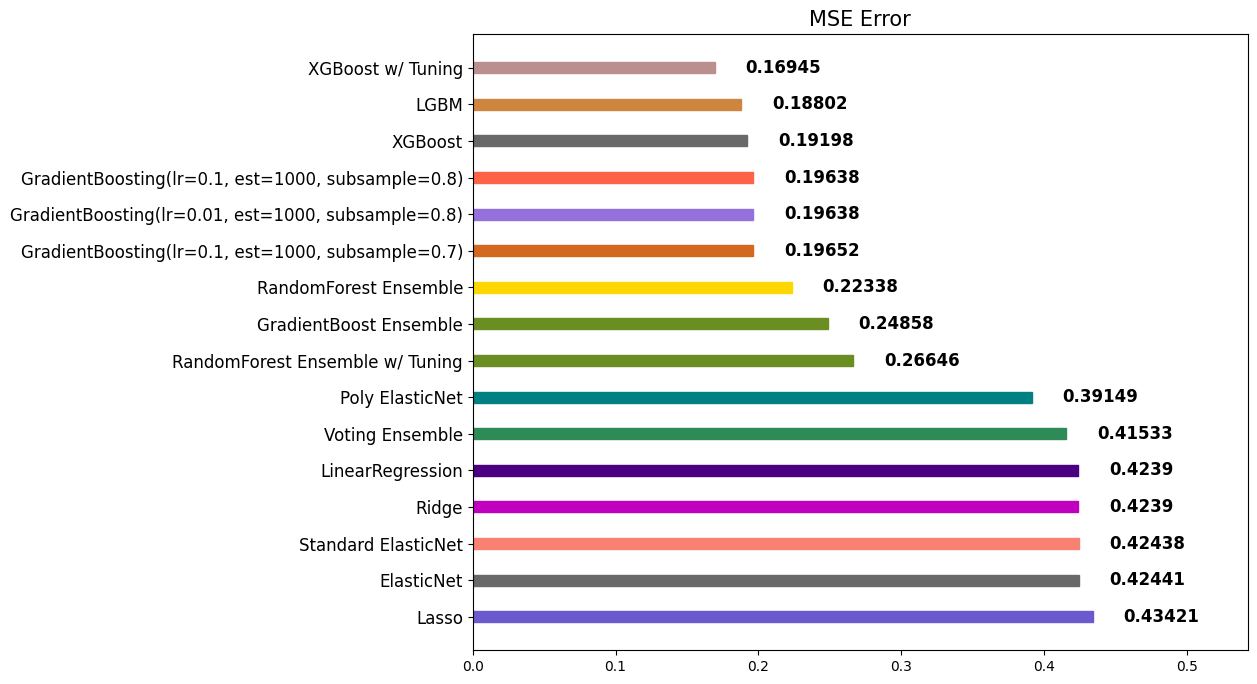

In [ ]:
utils.plot_error('LGBM', lgbm_pred, y_test)

**주요 Hyperparameter**
- `random_state`: 랜덤 시드 값. 고정해두고 튜닝할 것!
- `n_jobs`: CPU 사용 개수
- `learning_rate`: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1
- `n_estimators`: 부스팅 스테이지 수. (랜덤포레스트 트리의 개수 설정과 비슷한 개념). default=100
- `max_depth`: 트리의 깊이. 과대적합 방지용. default=3.
- `colsample_bytree`: 샘플 사용 비율 (max_features와 비슷한 개념). 과대적합 방지용. default=1.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15740, number of used features: 8
[LightGBM] [Info] Start training from score 1.921911


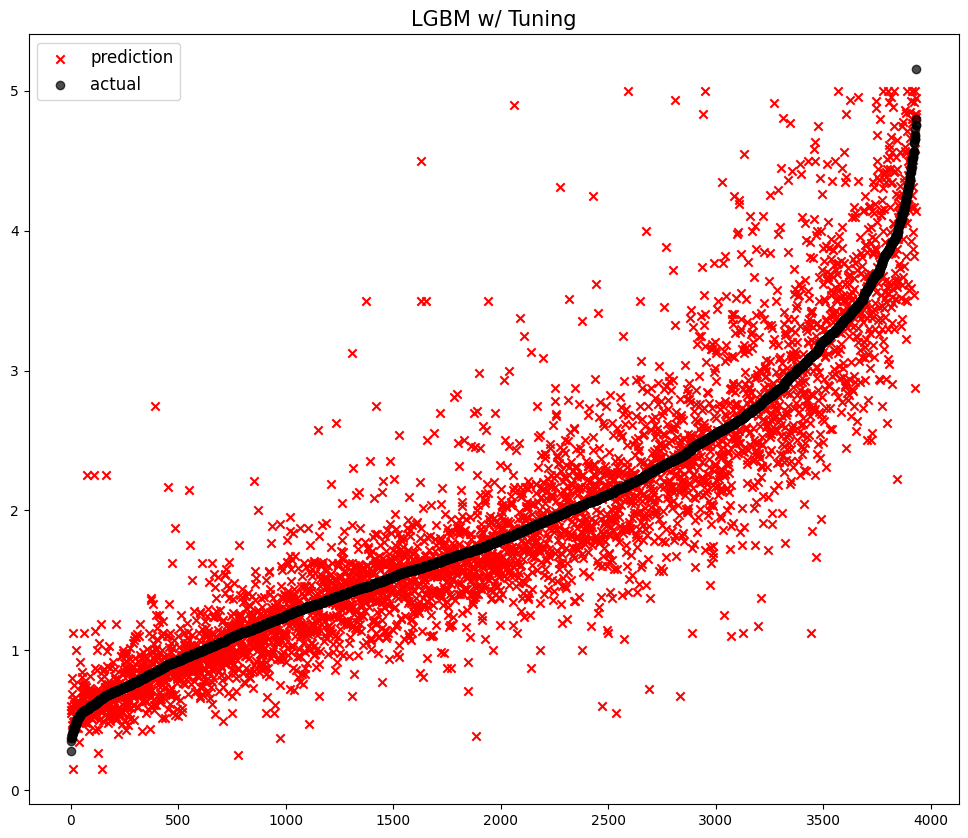

model     error
0                                               Lasso  0.434209
1                                          ElasticNet  0.424410
2                                 Standard ElasticNet  0.424381
3                                               Ridge  0.423898
4                                    LinearRegression  0.423897
5                                     Voting Ensemble  0.415333
6                                     Poly ElasticNet  0.391494
7                     RandomForest Ensemble w/ Tuning  0.266462
8                              GradientBoost Ensemble  0.248581
9                               RandomForest Ensemble  0.223379
10  GradientBoosting(lr=0.1, est=1000, subsample=0.7)  0.196520
11  GradientBoosting(lr=0.01, est=1000, subsample=...  0.196385
12  GradientBoosting(lr=0.1, est=1000, subsample=0.8)  0.196385
13                                            XGBoost  0.191983
14                                               LGBM  0.188020
15                                  XGBoost w/ Tuning  0.169448
16                                     LGBM w/ Tuning  0.168560

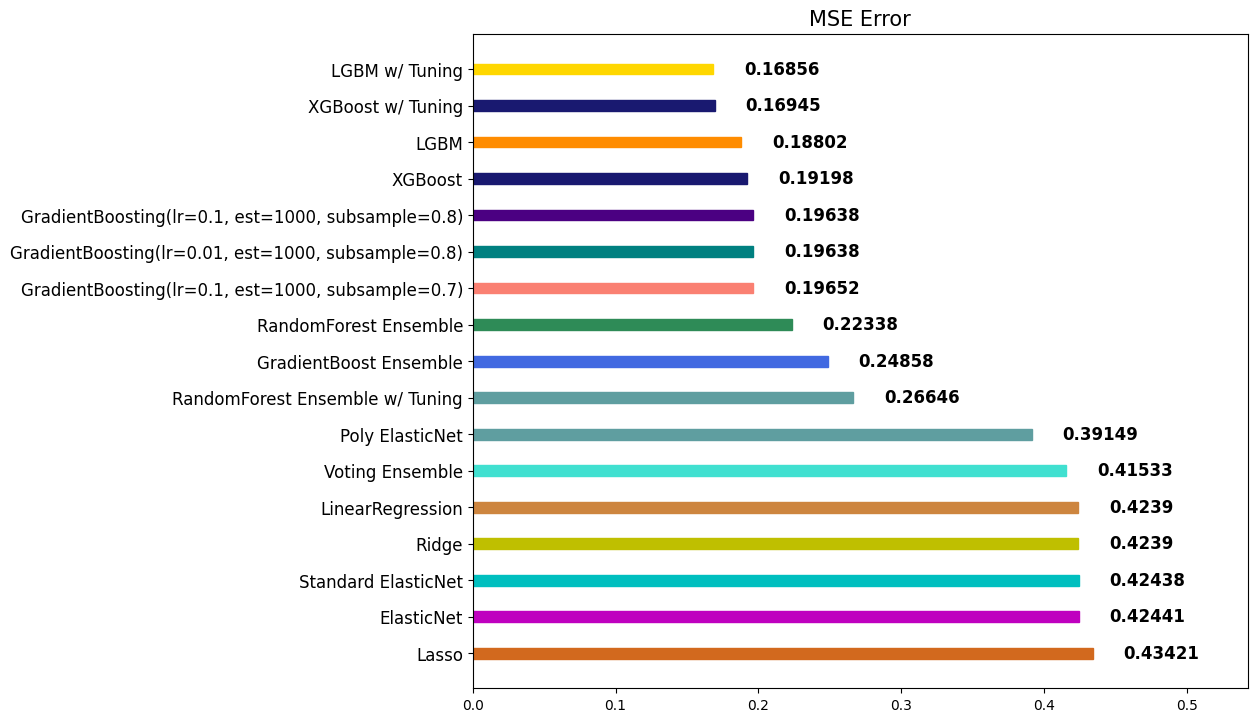

In [ ]:
lgbm = LGBMRegressor(random_state=42, learning_rate=0.1, n_estimators=1000, colsample_bytree=0.8, n_jobs=-1)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
utils.plot_error('LGBM w/ Tuning', lgbm_pred, y_test)

## Stacking

[공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html)

In [ ]:
from sklearn.ensemble import StackingRegressor

In [ ]:
stack_models = [
    ('elasticnet', poly_pipeline),
    ('randomforest', rfr),
    ('gbr', gbr),
    ('lgbm', lgbm),
]

In [ ]:
# 원래는 xgb 쓰려고 했는데 오류떠서 걍 릿지로 해보겟습니당..
stack_reg = StackingRegressor(estimators = stack_models, final_estimator=Ridge(), n_jobs=-1)

In [ ]:
stack_reg.fit(X_train, y_train)
stack_pred = stack_reg.predict(X_test)

# 성능 평가
stack_r2 = r2_score(y_test, stack_pred)
stack_mse = mean_squared_error(y_test, stack_pred)

print(f'R2 : {round(stack_r2, 4)}, MSE : {round(stack_mse, 4)}')

R2 : 0.8304, MSE : 0.1691


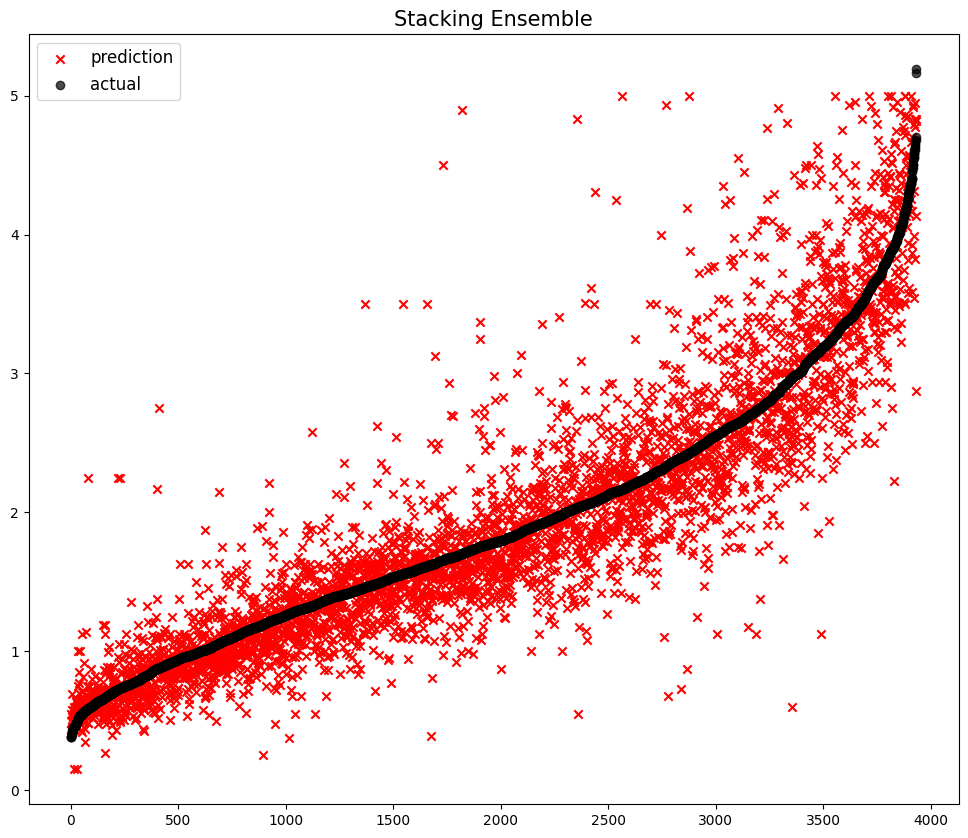

model     error
0                                               Lasso  0.434209
1                                          ElasticNet  0.424410
2                                 Standard ElasticNet  0.424381
3                                               Ridge  0.423898
4                                    LinearRegression  0.423897
5                                     Voting Ensemble  0.415333
6                                     Poly ElasticNet  0.391494
7                     RandomForest Ensemble w/ Tuning  0.266462
8                              GradientBoost Ensemble  0.248581
9                               RandomForest Ensemble  0.223379
10  GradientBoosting(lr=0.1, est=1000, subsample=0.7)  0.196520
11  GradientBoosting(lr=0.01, est=1000, subsample=...  0.196385
12  GradientBoosting(lr=0.1, est=1000, subsample=0.8)  0.196385
13                                            XGBoost  0.191983
14                                               LGBM  0.188020
15                                  XGBoost w/ Tuning  0.169448
16                                  Stacking Ensemble  0.169085
17                                     LGBM w/ Tuning  0.168560

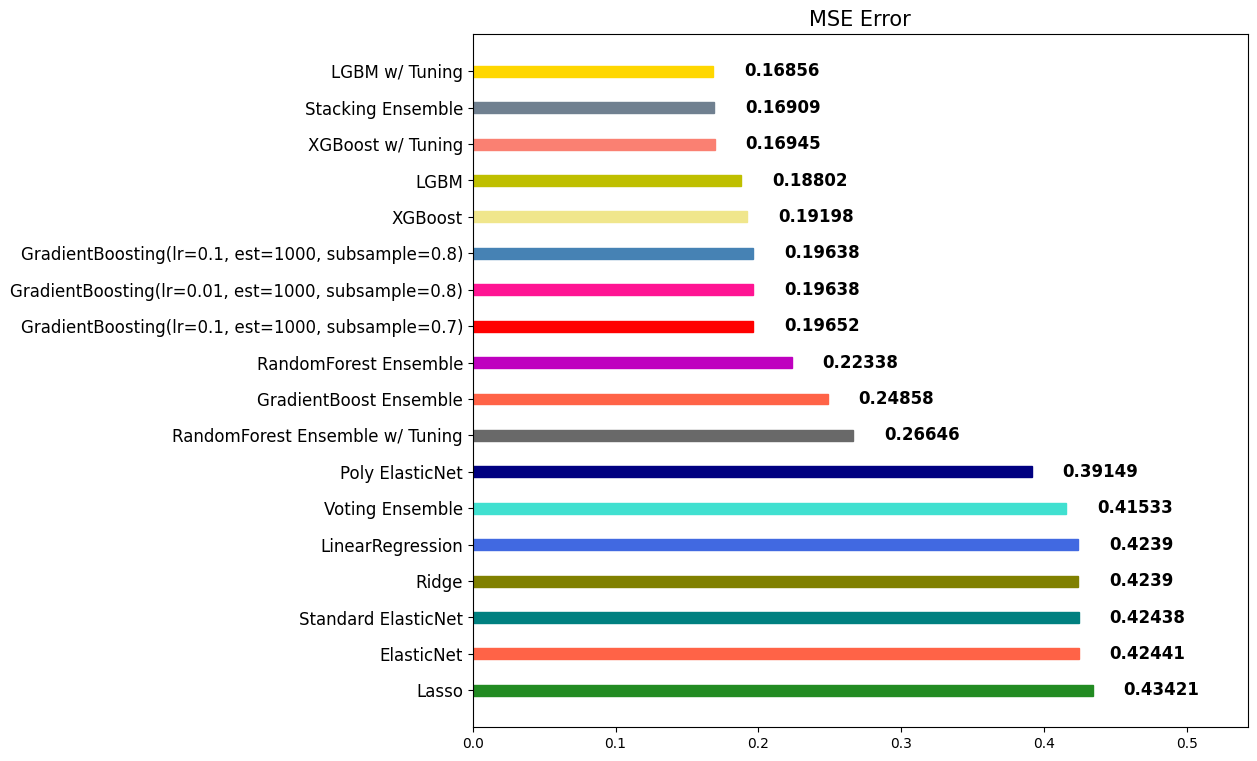

In [ ]:
utils.plot_error('Stacking Ensemble', stack_pred, y_test)

# 검증 (Validation)과 튜닝 (Tuning)

## Cross Validation

- Cross Validation이란 모델을 평가하는 하나의 방법입니다.
- K-겹 교차검증(K-fold Cross Validation)을 많이 활용합니다.

- **K-겹 교차검증**은 모든 데이터가 최소 한 번은 테스트셋으로 쓰이도록 합니다.

### K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [ ]:
n_splits = 5
kfold = KFold(n_splits=n_splits, random_state=9999, shuffle=True)

In [ ]:
lgbm_fold = LGBMRegressor(random_state=42, n_jobs=-1)

In [ ]:
i = 1
total_error = 0
for train_index, test_index in kfold.split(X):
    x_train_fold, x_valid_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[test_index]

    lgbm_pred_fold = lgbm_fold.fit(x_train_fold, y_train_fold).predict(x_valid_fold)
    error = mean_squared_error(lgbm_pred_fold, y_valid_fold)
    print('Fold = {}, prediction score = {:.2f}'.format(i, error))
    total_error += error
    i+=1
print('---'*10)
print('Average Error: %s' % (total_error / n_splits))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15740, number of used features: 8
[LightGBM] [Info] Start training from score 1.926282
Fold = 1, prediction score = 0.19
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15740, number of used features: 8
[LightGBM] [Info] Start training from score 1.930059
Fold = 2, prediction score = 0.18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train s

## Hyperparameter 튜닝

- hypterparameter 튜닝시 경우의 수가 너무 많습니다.
- 따라서, 우리는 자동화할 필요가 있습니다.

sklearn 패키지에서 자주 사용되는 hyperparameter 튜닝을 돕는 클래스는 다음 2가지가 있습니다.

1. **RandomizedSearchCV**
2. **GridSearchCV**

**적용하는 방법**

1. 사용할 Search 방법을 선택합니다.
2. hyperparameter 도메인을 설정합니다. (`max_depth`, `n_estimators`..등등)
3. 학습을 시킨 후, 기다립니다.
4. 도출된 결과 값을 모델에 적용하고 성능을 비교합니다.

## RandomizedSearchCV

- 모든 매개 변수 값이 시도되는 것이 아니라 지정된 분포에서 고정된 수의 매개변수 설정이 샘플링됩니다.
- 시도된 매개 변수 설정의 수는 `n_iter`에 의해 제공됩니다.

**주요 Hyperparameter (LGBM)**
- `random_state`: 랜덤 시드 값. 고정해두고 튜닝할 것!
- `n_jobs`: CPU 사용 개수
- `learning_rate`: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1
- `n_estimators`: 부스팅 스테이지 수. (랜덤포레스트 트리의 개수 설정과 비슷한 개념). default=100
- `max_depth`: 트리의 깊이. 과대적합 방지용. default=3.
- `colsample_bytree`: 샘플 사용 비율 (max_features와 비슷한 개념). 과대적합 방지용. default=1.0

In [ ]:
params = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.1, 0.05, 0.025],
    'max_depth': [6, 7, 8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

`n_iter` 값을 조절하여, 총 몇 회의 시도를 진행할 것인지 정의합니다.

(시도가 늘어나면, 더 좋은 parameter를 찾을 확률은 올라가지만, 그만큼 시간이 오래걸립니다.)

In [ ]:
clf = RandomizedSearchCV(LGBMRegressor(), params, random_state=42, cv=3, n_iter=25, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15740, number of used features: 8
[LightGBM] [Info] Start training from score 1.921911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'learning_rate': [0.1, 0.05, 0.025],
                                        'max_depth': [6, 7, 8],
                                        'n_estimators': [200, 500, 1000],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
abs(clf.best_score_)

np.float64(0.17264292304557105)

In [ ]:
clf.best_params_

{'subsample': 0.8,
 'n_estimators': 1000,
 'max_depth': 6,
 'learning_rate': 0.05,
 'colsample_bytree': 0.8}

In [ ]:
LGBMRegressor(**clf.best_params_)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              n_estimators=1000, subsample=0.8)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15740, number of used features: 8
[LightGBM] [Info] Start training from score 1.921911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

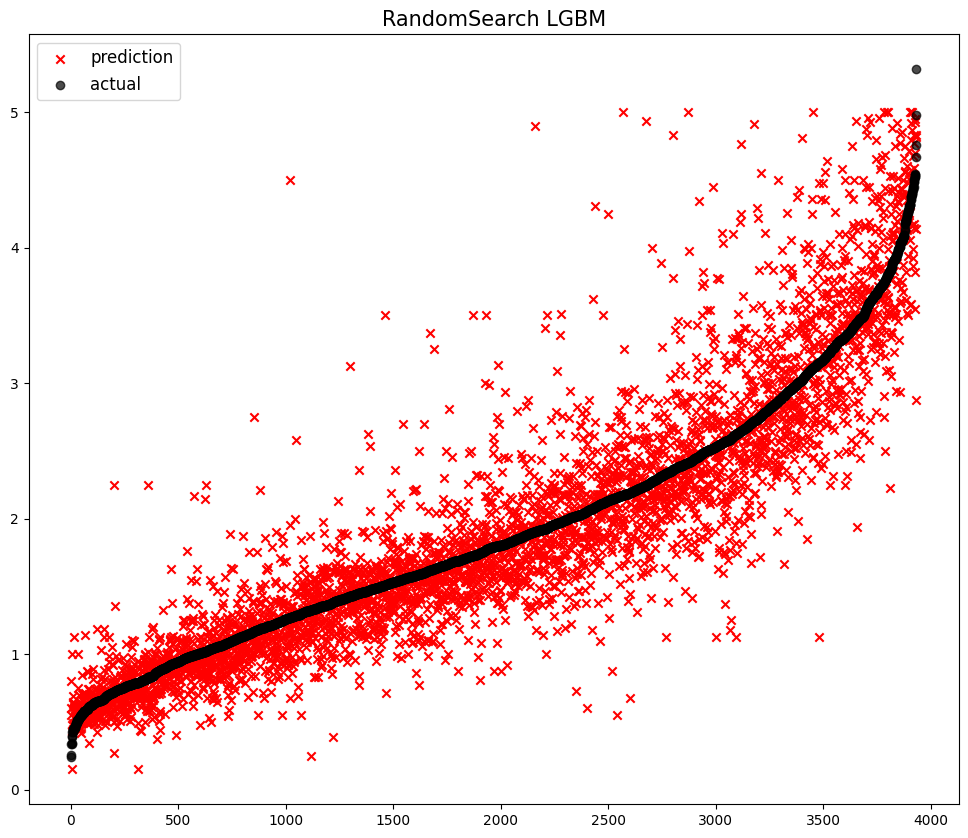

model     error
0                                               Lasso  0.434209
1                                          ElasticNet  0.424410
2                                 Standard ElasticNet  0.424381
3                                               Ridge  0.423898
4                                    LinearRegression  0.423897
5                                     Voting Ensemble  0.415333
6                                     Poly ElasticNet  0.391494
7                     RandomForest Ensemble w/ Tuning  0.266462
8                              GradientBoost Ensemble  0.248581
9                               RandomForest Ensemble  0.223379
10  GradientBoosting(lr=0.1, est=1000, subsample=0.7)  0.196520
11  GradientBoosting(lr=0.01, est=1000, subsample=...  0.196385
12  GradientBoosting(lr=0.1, est=1000, subsample=0.8)  0.196385
13                                            XGBoost  0.191983
14                                               LGBM  0.188020
15                                  RandomSearch LGBM  0.170242
16                                  XGBoost w/ Tuning  0.169448
17                                  Stacking Ensemble  0.169085
18                                     LGBM w/ Tuning  0.168560

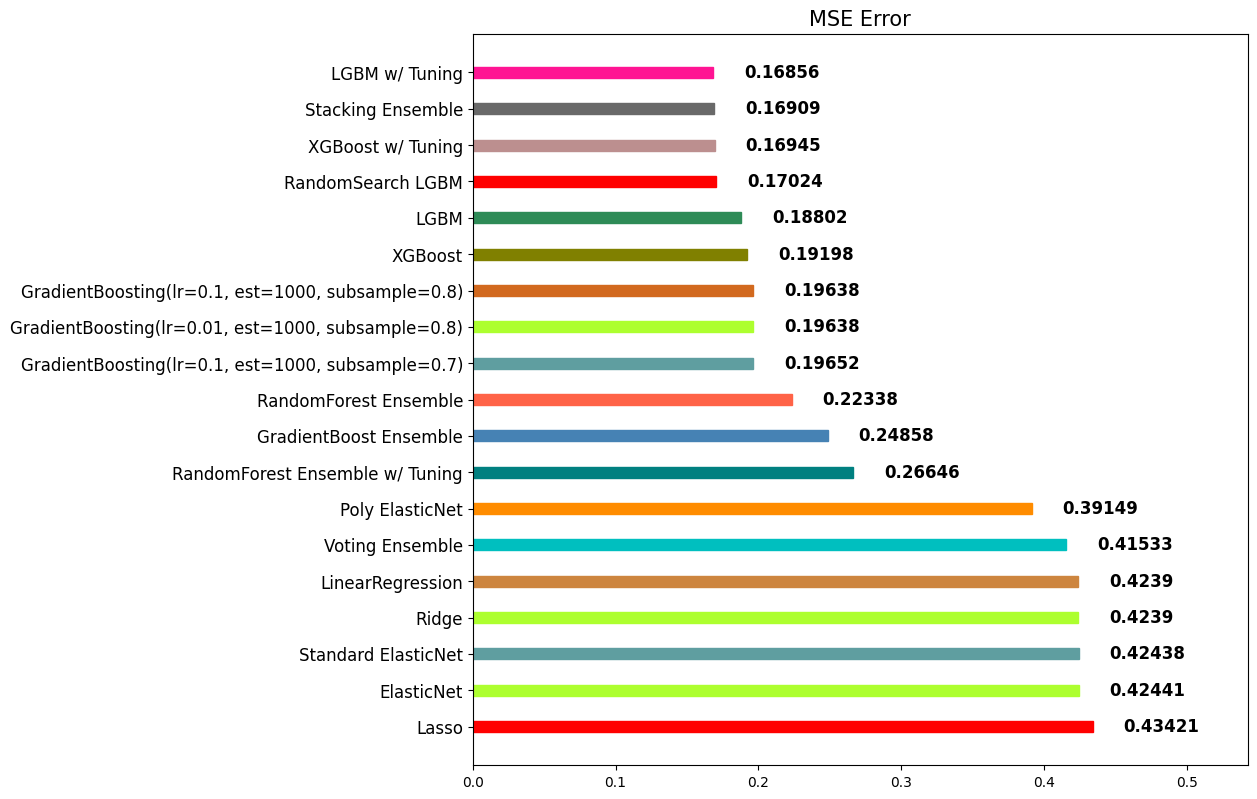

In [ ]:
lgbm_best = LGBMRegressor(**clf.best_params_)
lgbm_best.fit(X_train, y_train)
lgbm_best_pred = lgbm_best.predict(X_test)
utils.plot_error('RandomSearch LGBM', lgbm_best_pred, y_test)

## GridSearchCV

- 모든 매개 변수 값에 대하여 **완전 탐색**을 시도합니다.
- 따라서, 최적화할 parameter가 많다면, **시간이 매우 오래** 걸립니다.

In [ ]:
params = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.1, 0.05, 0.01],
    'num_leaves': [9, 12, 15],
    'colsample_bytree': [0.8, 0.9],
    'subsample': [0.8, 0.9,],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_search = GridSearchCV(LGBMRegressor(), params, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')

In [ ]:
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15740, number of used features: 8
[LightGBM] [Info] Start training from score 1.921911


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [500, 1000], 'num_leaves': [9, 12, 15],
                         'subsample': [0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [ ]:
abs(grid_search.best_score_)

np.float64(0.17374016071815324)

In [ ]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'n_estimators': 1000,
 'num_leaves': 15,
 'subsample': 0.8}

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15740, number of used features: 8
[LightGBM] [Info] Start training from score 1.921911


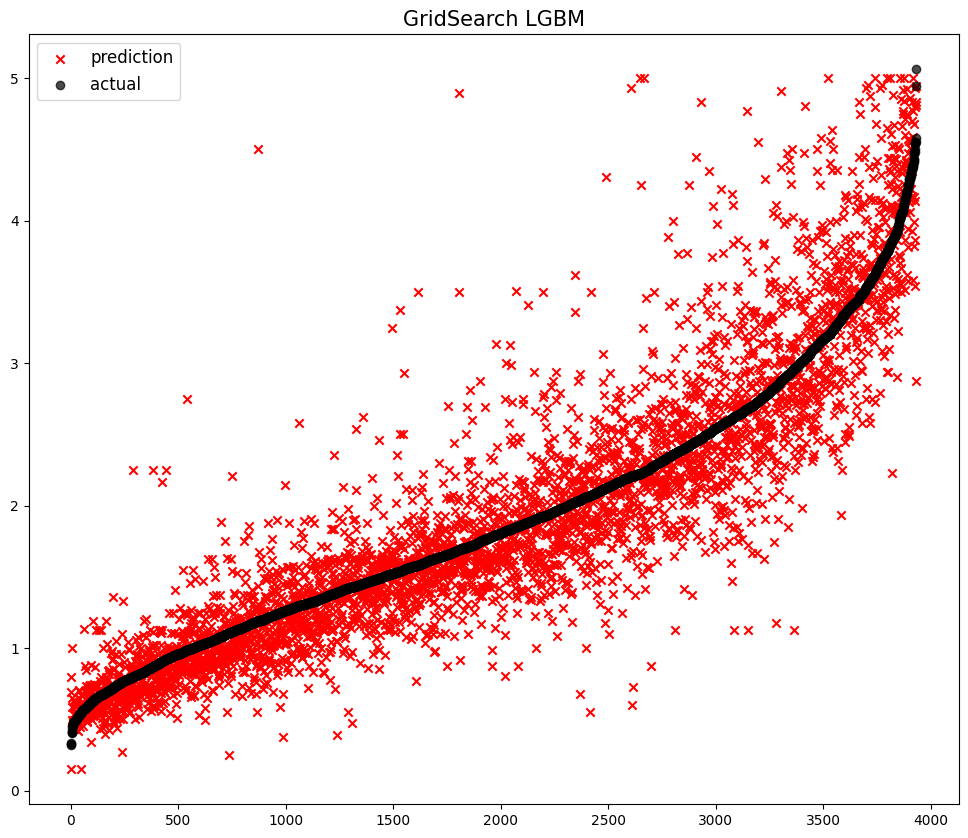

model     error
0                                               Lasso  0.434209
1                                          ElasticNet  0.424410
2                                 Standard ElasticNet  0.424381
3                                               Ridge  0.423898
4                                    LinearRegression  0.423897
5                                     Voting Ensemble  0.415333
6                                     Poly ElasticNet  0.391494
7                     RandomForest Ensemble w/ Tuning  0.266462
8                              GradientBoost Ensemble  0.248581
9                               RandomForest Ensemble  0.223379
10  GradientBoosting(lr=0.1, est=1000, subsample=0.7)  0.196520
11  GradientBoosting(lr=0.01, est=1000, subsample=...  0.196385
12  GradientBoosting(lr=0.1, est=1000, subsample=0.8)  0.196385
13                                            XGBoost  0.191983
14                                               LGBM  0.188020
15                                    GridSearch LGBM  0.172863
16                                  RandomSearch LGBM  0.170242
17                                  XGBoost w/ Tuning  0.169448
18                                  Stacking Ensemble  0.169085
19                                     LGBM w/ Tuning  0.168560

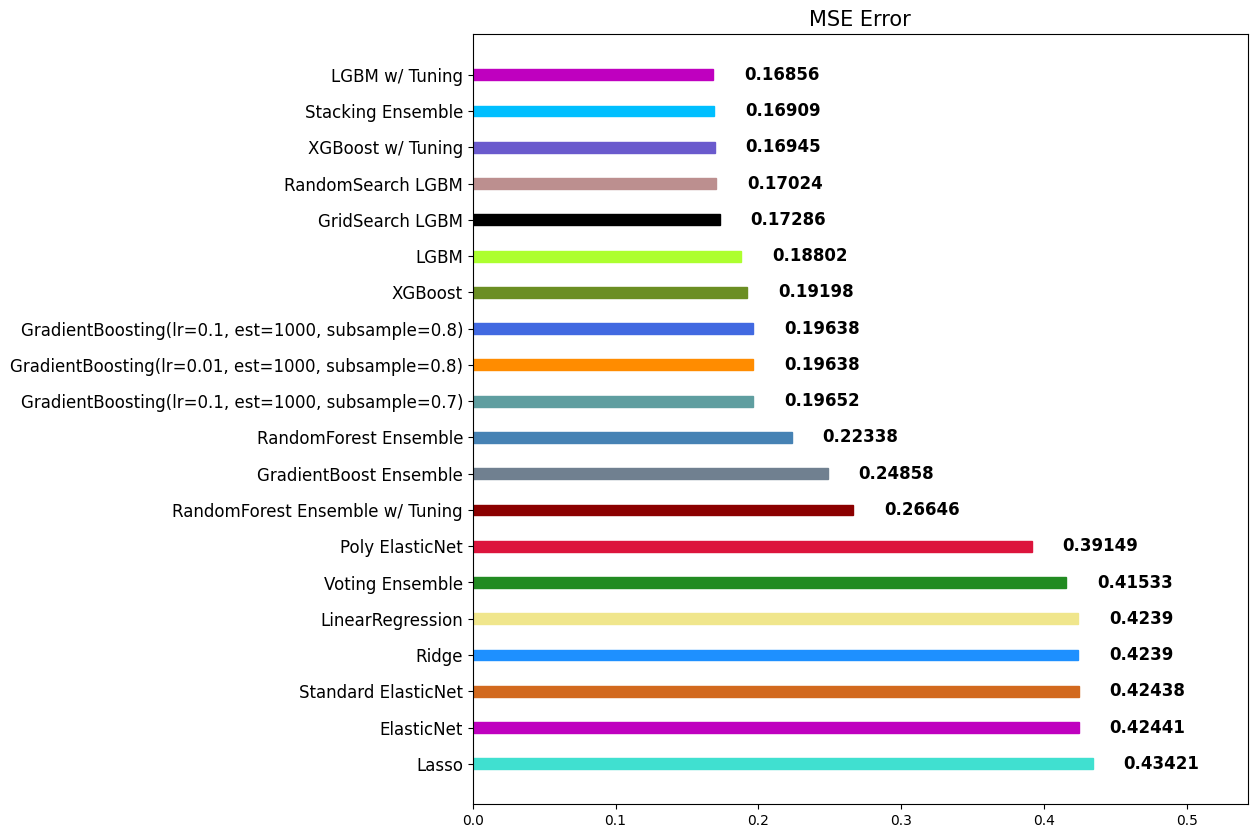

In [ ]:
lgbm_best = LGBMRegressor(**grid_search.best_params_)
lgbm_best.fit(X_train, y_train)
lgbm_best_pred = lgbm_best.predict(X_test)
utils.plot_error('GridSearch LGBM', lgbm_best_pred, y_test)

---
---
# [과제2] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등..을 수행해서  
아래 데이터셋을 활용해 더 높은 정확도를 가지는 모델을 만들어보세요!  
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다.   
이때 각 단계별로 어떤 방법을 수행했는지에 대한 주석을 꼼꼼히 달아주세요.  

- voting, bagging, boosting, stacking 중 어떤 모델을 사용하셔도 됩니다
- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.
- `random_state`는 모두 'SEED'로 고정해주세요.
- 모델을 출력하는 코드는 아래를 참고하세요

```python
model = #원하는 모델 넣기
model.fit(X_train, y_train)
y_model_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_model_pred)}")
```

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [3]:
# 데이터 분할 및 교차 검증
from sklearn.model_selection import cross_val_score

# 성능 평가 지표
from sklearn.metrics import accuracy_score, classification_report

# 기본 분류 모델
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 앙상블 모델
from sklearn.ensemble import (
    VotingClassifier,      # 보팅
    BaggingClassifier,     # 배깅
    RandomForestClassifier, # 랜덤 포레스트
    AdaBoostClassifier,    # 에이다부스트
    GradientBoostingClassifier, # 그래디언트 부스팅
    StackingClassifier     # 스태킹
)

# 부스팅 라이브러리
import xgboost as xgb           # XGBoost
import lightgbm as lgb          # LightGBM
from catboost import CatBoostClassifier  # CatBoost

SEED = 42

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


drive 데이터를 가져오기 위해 mount한다.

In [90]:
# ===== 데이터 준비 =====
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/advanced/session01/Telco-Customer-Churn.csv')

target = 'Churn'
X = df.drop(columns=[target, 'customerID'])
y = df[target].map({'Yes': 1, 'No': 0})

## 데이터셋 소개: Telco Customer Churn

<a>https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download

### 데이터셋 설명
- **출처**: IBM Sample Data / Kaggle
- **문제 유형**: 이진 분류 (Binary Classification)
- **예측 목표**: 고객의 이탈 여부 예측 (Churn: Yes/No)
- **데이터 크기**: 7,043개 행, 21개 열
- **실무 활용**: 통신사, 구독 서비스 등에서 고객 이탈 방지 전략 수립에 활용

### 주요 특징
- **클래스 불균형**: 이탈 고객 약 27%, 유지 고객 약 73%
- **다양한 변수 유형**: 범주형 변수와 수치형 변수 혼합
- **실무 유사성**: 실제 비즈니스 문제와 매우 유사한 구조

### 변수 설명

#### 1. 고객 정보
- `customerID`: 고객 ID (분석에서 제외)
- `gender`: 성별 (Male/Female)
- `SeniorCitizen`: 고령자 여부 (0/1)
- `Partner`: 배우자 유무 (Yes/No)
- `Dependents`: 부양가족 유무 (Yes/No)

#### 2. 서비스 정보
- `tenure`: 서비스 이용 개월 수
- `PhoneService`: 전화 서비스 가입 여부
- `MultipleLines`: 복수 회선 여부
- `InternetService`: 인터넷 서비스 유형 (DSL/Fiber optic/No)
- `OnlineSecurity`: 온라인 보안 서비스
- `OnlineBackup`: 온라인 백업 서비스
- `DeviceProtection`: 기기 보호 서비스
- `TechSupport`: 기술 지원 서비스
- `StreamingTV`: TV 스트리밍 서비스
- `StreamingMovies`: 영화 스트리밍 서비스

#### 3. 계약 정보
- `Contract`: 계약 유형 (Month-to-month/One year/Two year)
- `PaperlessBilling`: 전자 청구서 사용 여부
- `PaymentMethod`: 결제 방법
- `MonthlyCharges`: 월 요금
- `TotalCharges`: 총 납부 금액

#### 4. 타겟 변수
- `Churn`: 이탈 여부 (Yes/No) - **예측 목표**

# 전처리

In [166]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/advanced/session01/Telco-Customer-Churn.csv')
df = df.drop('customerID', axis=1)


totalcharges 타입 변환 및 결측치 채우기

In [167]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df['TotalCharges'].isnull().sum()

np.int64(0)

In [168]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for i in binary_cols:
    df[i] = df[i].map({'Yes': 1, 'No': 0})

multi_cat_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True, dtype=int)

인코딩은 완료했고, 이제 수치형 변수들을 스케일링 해주려 한다.

In [169]:
from sklearn.preprocessing import StandardScaler
scale_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])
df_scaled[scale_cols].head()

tenure  MonthlyCharges  TotalCharges
0 -1.277445       -1.160323     -0.994242
1  0.066327       -0.259629     -0.173244
2 -1.236724       -0.362660     -0.959674
3  0.514251       -0.746535     -0.194766
4 -1.236724        0.197365     -0.940470

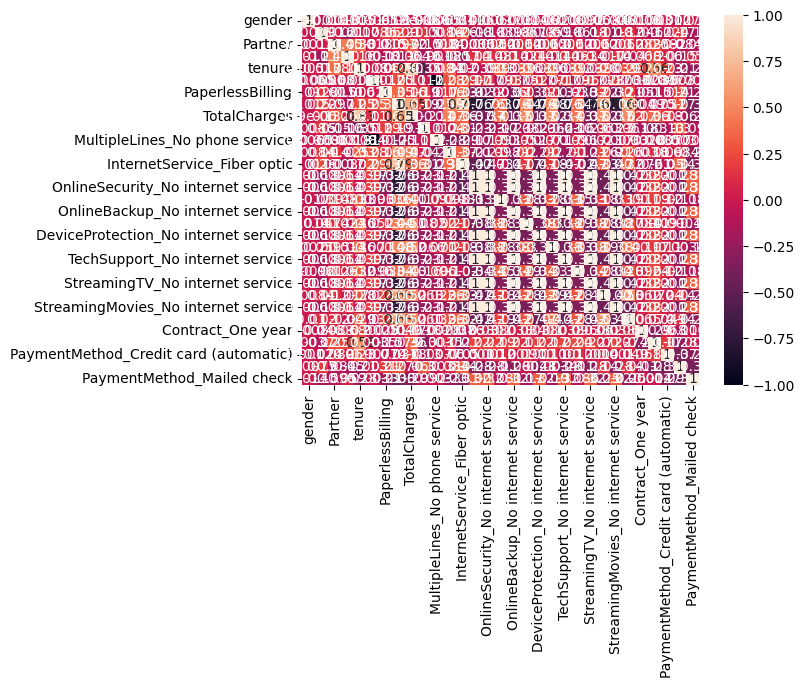

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.corr(), annot = True)
plt.show()

문제가 있어 보인다.

In [171]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

X = df_scaled.drop('Churn', axis=1)
X_vif = add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values(by='VIF', ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


feature           VIF
6                           PhoneService           inf
10        MultipleLines_No phone service           inf
16      OnlineBackup_No internet service  1.510804e+10
13                    InternetService_No  2.825641e+09
14    OnlineSecurity_No internet service  2.825641e+09
18  DeviceProtection_No internet service  1.432468e+09
20       TechSupport_No internet service  5.719944e+08
22       StreamingTV_No internet service  5.498567e+08
24   StreamingMovies_No internet service  1.089532e+08
8                         MonthlyCharges  8.632969e+02

No internet service가 포함된 컬럼을 없앨 것이다.
추가로 다중공선성이 높은 컬럼도 없앴다.

In [172]:
df_drop = df_scaled.drop(labels=['PhoneService', 'MultipleLines_No phone service', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service'
                                 ,'MonthlyCharges', 'TotalCharges'], axis=1)

In [173]:
X = df_drop.drop('Churn', axis=1)
X_vif = add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data.sort_values(by='VIF', ascending=False).head()

feature        VIF
0                            const  13.375290
5                           tenure   2.748182
16               Contract_Two year   2.413415
18  PaymentMethod_Electronic check   1.962956
19      PaymentMethod_Mailed check   1.818256

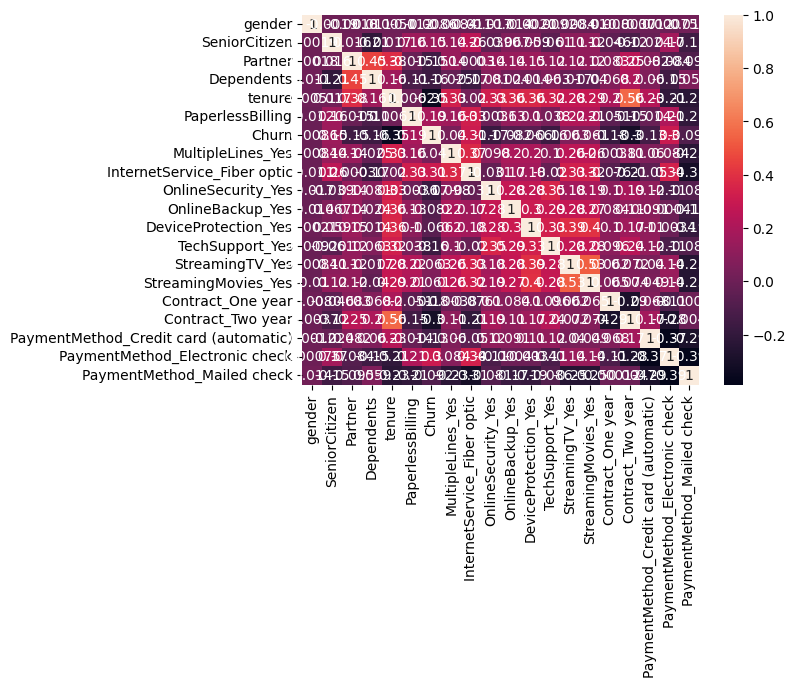

gender  SeniorCitizen  Partner  Dependents    tenure  PaperlessBilling  \
0       0              0        1           0 -1.277445                 1   
1       1              0        0           0  0.066327                 0   
2       1              0        0           0 -1.236724                 1   
3       1              0        0           0  0.514251                 0   
4       0              0        0           0 -1.236724                 1   

   Churn  MultipleLines_Yes  InternetService_Fiber optic  OnlineSecurity_Yes  \
0      0                  0                            0                   0   
1      0                  0                            0                   1   
2      1                  0                            0                   1   
3      0                  0                            0                   1   
4      1                  0                            1                   0   

   OnlineBackup_Yes  DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
0                 1                     0                0                0   
1                 0                     1                0                0   
2                 1                     0                0                0   
3                 0                     1                1                0   
4                 0                     0                0                0   

   StreamingMovies_Yes  Contract_One year  Contract_Two year  \
0                    0                  0                  0   
1                    0                  1                  0   
2                    0                  0                  0   
3                    0                  1                  0   
4                    0                  0                  0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0

In [174]:
sns.heatmap( df_drop.corr(), annot = True)
plt.show()
df_drop.head()

In [175]:
target = 'Churn'
X = df_drop.drop('Churn', axis=1)
y = df_drop['Churn']

In [176]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## DecisionTreeClassifier
0.7977

In [30]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=SEED)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"DecisionTreeClassifier: {accuracy:.4f}")

DecisionTreeClassifier: 0.7871


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [2, 3, 5, 7, 10],
    'min_samples_split': [2, 4, 8, 12],
    'min_samples_leaf': [1, 2, 4, 6]
}

dt_clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

best_score = grid_search.best_score_

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"DecisionTreeClassifier + Grid: {accuracy:.4f}")


{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier + Grid: 0.7977


In [29]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    'max_depth': [2, 3, 5, 7, 10, None],
    'min_samples_split': [2, 4, 8, 12, 16],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

dt_clf = DecisionTreeClassifier(random_state=SEED)
random_search = RandomizedSearchCV(estimator=dt_clf, param_distributions=param_distributions, n_iter=50, cv=5, scoring='accuracy', random_state=SEED, n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(best_params)
best_dt = random_search.best_estimator_
y_pred = best_dt.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"DecisionTreeClassifier + Random: {final_accuracy:.4f}")

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7}
DecisionTreeClassifier + Random: 0.7977


## SVC
0.7906

In [31]:
from sklearn.svm import SVC
svc_clf = SVC(random_state=SEED)
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)
print(f"SVC 정확도: {accuracy_score(y_test, y_pred):.4f}")

SVC 기본 정확도: 0.7892


In [33]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'auto'],
    'kernel': ['rbf', 'linear']
}

svc_clf = SVC(random_state=SEED)
grid_search = GridSearchCV(estimator=svc_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVC + Grid: {accuracy:.4f}")

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
SVC + Grid: 0.7906


In [38]:
param_distributions = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 'auto'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc_clf = SVC(random_state=SEED)
random_search = RandomizedSearchCV(
    estimator=svc_clf,
    param_distributions=param_distributions,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=SEED,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print(best_params)

best_svc = random_search.best_estimator_
y_pred = best_svc.predict(X_test)
print(f"SVC + Random: {accuracy_score(y_test, y_pred):.4f}")

KeyboardInterrupt: 

## KNeighborsClassifier
0.7786

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print(f"KNeighborsClassifier 정확도: {accuracy_score(y_test, y_pred):.4f}")

KNeighborsClassifier 정확도: 0.7594


In [37]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print(f"KNeighborsClassifier + Grid: {accuracy_score(y_test, y_pred):.4f}")

{'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
KNeighborsClassifier + Grid: 0.7786


In [39]:
param_distributions = {
    'n_neighbors': list(range(1, 11)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_clf = KNeighborsClassifier()
random_search = RandomizedSearchCV(estimator=knn_clf, param_distributions=param_distributions, n_iter=50, cv=5, scoring='accuracy', random_state=SEED, n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(best_params)

best_knn = random_search.best_estimator_
y_pred = best_knn.predict(X_test)
print(f"KNeighborsClassifier + Random: {accuracy_score(y_test, y_pred):.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'weights': 'uniform', 'p': 2, 'n_neighbors': 8}
KNeighborsClassifier + Random: 0.7779


## RandomForestClassifier
0.8048261178140526

In [185]:
from sklearn.ensemble import RandomForestClassifier

rfc_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=5,
    max_features='sqrt',
    random_state=SEED
)
rfc_clf.fit(X_train, y_train)

y_pred = rfc_clf.predict(X_test)
print(f"RandomForestClassifier: {accuracy_score(y_test, y_pred)}")

RandomForestClassifier: 0.8048261178140526


In [42]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 4]
}

rfc_clf = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(estimator=rfc_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

best_rfc = grid_search.best_estimator_
y_pred = best_rfc.predict(X_test)
print(f"RandomForestClassifier + Grid: {accuracy_score(y_test, y_pred)}")

{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
RandomForestClassifier + Grid: 0.8019872249822569


## GradientBoostingClassifier

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=SEED)
gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)
print(f"GradientBoostingClassifier 정확도: {accuracy_score(y_test, y_pred)}")

GradientBoostingClassifier 정확도: 0.794180269694819


In [45]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

gb_clf = GradientBoostingClassifier(random_state=SEED)
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test)
print(f"GradientBoostingClassifier + Grid: {accuracy_score(y_test, y_pred):.4f}")

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
GradientBoostingClassifier + Grid: 0.7949


## xgboost
0.794180269694819

In [139]:
xgb_clf = xgb.XGBClassifier(
    subsample=0.8,
    n_estimators=2000,
    max_depth=3,
    learning_rate=0.005,
    colsample_bytree=0.9,
    eval_metric='mlogloss',
    random_state=SEED,
    device='cuda'
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print(f"XGBClassifier: {accuracy_score(y_test, y_pred)}")

XGBClassifier: 0.794180269694819


In [60]:
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=SEED, device='cuda')
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_distributions, n_iter=50, cv=5, scoring='accuracy', random_state=SEED, n_jobs=-1)

#random_search.fit(X_train, y_train, device='cuda')
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(best_params)

best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print(f"XGBClassifier + Random: {accuracy_score(y_test, y_pred)}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:46:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
XGBClassifier + Random: 0.7920511000709723


## CatBoostClassifier
0.8055358410220014

In [218]:
cat_clf = CatBoostClassifier(
    iterations=1000,
    depth=3,
    l2_leaf_reg=1,
    learning_rate=0.01,
    subsample=0.8,
    random_seed=SEED,
    verbose=0
)

cat_clf.fit(X_train, y_train)
y_pred = cat_clf.predict(X_test)

print(f"CatBoostClassifier 정확도: {accuracy_score(y_test, y_pred)}")

CatBoostClassifier 정확도: 0.8055358410220014


### 원래 코드

In [38]:
model = xgb.XGBClassifier(random_state=SEED) #원하는 모델 넣기
model.fit(X_train, y_train)
y_model_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_model_pred)}")

Model Accuracy: 0.7735982966643009


마지막으로, 아래 내용을 마크다운 셀에 정리해주세요
- 1. 과제 1 실행해보며 느낀 점
- 2. 과제 2에서 사용한 모델
- 3. 과제 2 모델 튜닝할 때 사용한 방법, 그리고 그렇게 해서 찾은 하이퍼파라미터값
- 4. 튜닝한 모델로 예측한 결과 (바로 위 셀 출력 결과 복사 붙여넣기)

> 모델 정확도가 가장 높은 3인에게는 깜짝 선물이!!

# 여기에 내용 정리해주세요!

### 1. 과제 1 실행해보며 느낀 점
- 개념으로만 알고 있던 앙상블을 직접 실행할 수 있어서 기분이 좋았다.
- 구글 코랩으로 했는데도 그리드서치가 생각보다 매우 오래 걸려서 놀랐다.

### 2. 과제 2에서 사용한 모델
- DecisionTreeClassifier
- SVC
- KNeighborsClassifier
- RandomForestClassifier
- GradientBoostingClassifier
- xgboost
- CatBoostClassifier

### 3. 과제 2 모델 튜닝할 때 사용한 방법, 그리고 그렇게 해서 찾은 하이퍼파라미터값
- 가장 높게 나온 모델은 CatBoostClassifier이다.
- 몇몇은 그리드 서치와 랜덤 서치를 같이 했으나, 너무 오래 걸려 나중에는 둘 중 하나만 쓰거나 직접 대입하며 조금씩 값을 바꿨다.
- `iterations=1000,
    depth=3,
    l2_leaf_reg=1,
    learning_rate=0.01,
    subsample=0.8,
    random_seed=SEED,
    verbose=0`

### 4. 튜닝한 모델로 예측한 결과
CatBoostClassifier 정확도: 0.8055358410220014